<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/main/CAN_Models_Timediff_20240628.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리  
- 각 ID별로 Timediff 값 추가
- 몇 ID가 test데이터에 공격데이터의 수가 부족해 테스트가 안되는 문제가 발생
- 따라서 디코딩 과정에서 데이터 수가 너무 많아 split했던 data들을 각 ID별로 concat해서 데이터의 양을 늘림


---  
**<데이터 크기로 인한 split 과정>**  
Pre_train_D_1 ->
  - decoded_can_data_AddDLC_1_0 ->
      - /filtered_data_AddDLC_1_0/pre_train_D_1_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_1_1 ->
      - /filtered_data_AddDLC_1_1/pre_train_D_1_1_ID_{id}   (총 56개)

Pre_train_D_2 ->
  - decoded_can_data_AddDLC_2_0 ->
      - /filtered_data_AddDLC_2_0/pre_train_D_2_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_2_1 ->
      - /filtered_data_AddDLC_2_1/pre_train_D_2_1_ID_{id}   (총 56개)

=> 총 224개의 파일 생성

**<학습을 위한 concat과정>**   
 동일한 id  
combined_df ->
 - pre_train_D_**1_0**_ID_{id} + pre_train_D_**1_1**_ID_{id} + pre_train_D_**2_0**_ID_{id} + pre_train_D_**2_1**_ID_{id}

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 주어진 ID 리스트
ids = ['251', '2B0', '381', '340', '260', '47F', '329', '164', '387', '394',
       '4F1', '130', '140', '356', '153', '220', '366', '367', '368', '412',
       '470', '38D', '420', '421', '389', '386', '492', '391', '485', '490',
       '593', '484', '48A', '50C', '58B', '436', '541', '507', '4A7', '520',
       '53E', '495', '500', '483', '4A2', '50A', '043', '52A', '544', '553',
       '559', '410', '563', '07F', '57F', '5B0']

# 빈도수 분포; ID 별 메시지 TimeDelta 값(ms)
can_freqs = {'000': 2.0,
      '043': 1.0, '07F': 1.0, '130': 0.01, '140': 0.01, '153': 0.01, '164': 0.01, '220': 0.01, '251': 0.01,
      '260': 0.01, '2B0': 0.01, '329': 0.01, '340': 0.01, '356': 0.01, '366': 0.01, '367': 0.01, '368': 0.01, '381': 0.02,
      '386': 0.02, '387': 0.02, '389': 0.02, '38D': 0.02, '391': 0.02, '394': 0.02, '410': 0.2, '412': 0.2, '420': 0.02,
      '421': 0.02, '42D': 0.1, '436': 0.05, '44E': 0.2, '453': 0.02, '470': 0.02, '479': 0.1, '47F': 0.02, '483': 0.2,
      '484': 0.07, '485': 0.05, '48A': 0.05, '48C': 0.2, '490': 0.05, '492': 0.05, '495': 0.1, '49F': 0.2, '4A2': 0.5,
      '4A4': 2.0, '4A7': 0.5, '4A9': 0.2, '4C9': 0.2, '4CB': 0.2, '4F1': 0.02, '500': 0.1, '507': 0.1, '50A': 0.2,
      '50C': 0.1, '50E': 0.2, '520': 0.1, '52A': 0.2, '53B': 0.2, '53E': 0.1, '53F': 0.2, '541': 0.1, '544': 0.2,
      '553': 0.2, '559': 0.2, '563': 0.5, '568': 0.1, '572': 0.2, '57F': 1.5, '58B': 0.05, '593': 0.2, '5A6': 0.2,
      '5B0': 1.0, '5BE': 1.0, '5CD': 0.2, '7C4': 2.0, '7CC': 2.0, '7D0': 2.0, '7D4': 2.0, '7D8': 2.0, '7DC': 2.0 }

In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(1, 3):  # 2개의 폴더를 처리할 것으로 가정
        for j in range(2):  # ID가 0과 1인 두 가지 경우를 처리할 것으로 가정
            file_path = f'/content/drive/MyDrive/CAN/Decoding_data_Timediff_20240627/H-SCOPE/filtered_data_AddDLC_{folder_number}_{j}/pre_train_D_{folder_number}_{j}_ID_{id}.csv'
            try:
                df = pd.read_csv(file_path)
                id_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id['df_394_combined']['ACCEnable']

0        SCC permanent fault
1        SCC permanent fault
2        SCC permanent fault
3        SCC permanent fault
4        SCC permanent fault
                ...         
33057    SCC permanent fault
33058    SCC permanent fault
33059    SCC permanent fault
33060    SCC permanent fault
33061    SCC permanent fault
Name: ACCEnable, Length: 33062, dtype: category
Categories (4, object): ['SCC permanent fault', 'SCC permanent fault, communication issue', 'SCC ready',
                         'SCC temp fault']

## 학습, 테스트 데이터 split & 모델 학습

In [ ]:
SEED = 42

# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# SVC MODEL

from sklearn.svm import SVC
svc = SVC(random_state = SEED)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=50000)

# Train RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfe = RandomForestClassifier(max_depth=6)

# Train LightGBM Classifier
from lightgbm import LGBMClassifier
lgbmc = LGBMClassifier(random_state=SEED)

# Train Gradient-Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
grb = GradientBoostingClassifier(learning_rate=1.1)

In [ ]:
# Train XGBOOST Classifier
from xgboost import XGBClassifier
params = {
              'objective': 'multi:softmax',  # 다중 클래스 분류 문제
              'n_estimators': 100,
              'max_depth': 6,
              'eta': 0.2,     #0.3
              'eval_metric': 'merror',        # 분류 오차 평가 지표
              'lambda' : 1,                   #L2 정규화
              'alpha' : 0.5                   #L1 정규화
          }

xgbc = XGBClassifier(params, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTree']= dtc
# models['Gaussian Naive Bayes']= gnb
# models['Bernoulli Naive Bayes']= bnb
# models['Gradient Boosting']= grb
models['Random Forest']= rfe
models['XGBoost']=xgbc

In [ ]:
# id별 학습 및 테스트 셋
def id_train_test(dfs_by_id, data_id, _models):
    preds={}
    modelAcc={}

    # 데이터프레임 선택
    df_combined = dfs_by_id[f'df_{data_id}_combined']
    train_classes = df_combined['SubClass'].nunique()

    # 타겟 변수와 특징 변수 분리
    X = df_combined.drop(['SubClass', 'Arbitration_ID'], axis=1)
    y = df_combined['SubClass']

    categorical_columns = X.select_dtypes(include=['category']).columns
    X = pd.get_dummies(X, columns=categorical_columns)

    # 데이터를 학습용과 테스트용으로 분할
    # suffle = False ? -> 일단 시계열 데이터니까 안 섞어야 되는 건감?
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # 클래스 레이블을 숫자로 인코딩
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    for name in _models:
        models[name].fit(X_train, y_train_encoded)
        preds[name] = models[name].predict(X_test)
        modelAcc[name] = accuracy_score(y_test_encoded, preds[name])

    return y_test_encoded, preds, modelAcc, label_encoder.classes_

## 모델 성능 평가

###All ID accuracy test

Processing ID: 251
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       401
      Normal       1.00      1.00      1.00     25647
      Replay       0.98      0.89      0.93       424

    accuracy                           1.00     26472
   macro avg       0.99      0.96      0.98     26472
weighted avg       1.00      1.00      1.00     26472



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       401
      Normal       1.00      1.00      1.00     25647
      Replay       0.99      0.96      0.98       424

    accuracy                           1.00     26472
   macro avg       1.00      0.99      0.99     26472
weighted avg       1.00      1.00      1.00     26472



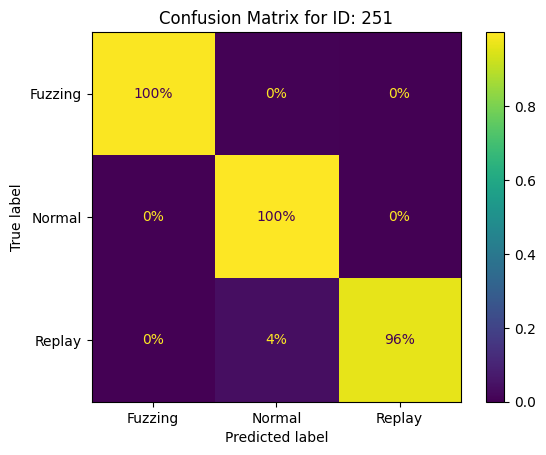

<Figure size 800x600 with 0 Axes>



Result 251 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          251  0.997922  0.997899  0.997922  0.997875
XGBoost                251  0.999207  0.999204  0.999207  0.999201


Processing ID: 2B0
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       372
      Normal       1.00      1.00      1.00     25670
      Replay       0.99      0.88      0.93       394

    accuracy                           1.00     26436
   macro avg       1.00      0.96      0.98     26436
weighted avg       1.00      1.00      1.00     26436



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       372
      Normal       1.00      1.00      1.00     25670
      Replay       0.99      0.96      0.98       394

    accuracy                           1.00     26436
   macro avg       1.00      0.99      0.99     26436
weighted avg       1.00      1.00      1.00     26436



<Figure size 800x600 with 0 Axes>



Result 2B0 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          2B0  0.998109  0.998097  0.998109  0.998054
XGBoost                2B0  0.999319  0.999316  0.999319  0.999314


Processing ID: 381
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       206
      Normal       1.00      1.00      1.00     12834
      Replay       0.99      0.84      0.91       193

    accuracy                           1.00     13233
   macro avg       1.00      0.95      0.97     13233
weighted avg       1.00      1.00      1.00     13233



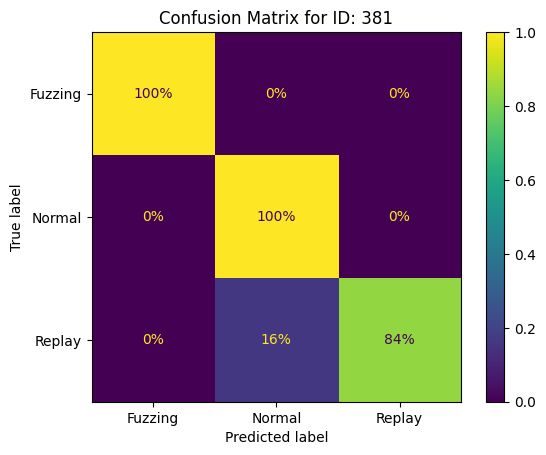

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       206
      Normal       1.00      1.00      1.00     12834
      Replay       0.98      0.92      0.95       193

    accuracy                           1.00     13233
   macro avg       0.99      0.97      0.98     13233
weighted avg       1.00      1.00      1.00     13233



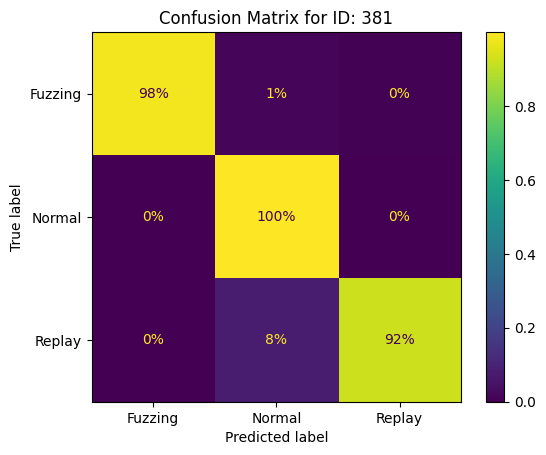

<Figure size 800x600 with 0 Axes>



Result 381 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          381  0.997506  0.997485  0.997506  0.997406
XGBoost                381  0.998337  0.998321  0.998337  0.998315


Processing ID: 340
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       201
      Normal       1.00      1.00      1.00     25658
      Replay       0.99      0.88      0.93       410

    accuracy                           1.00     26269
   macro avg       0.99      0.96      0.98     26269
weighted avg       1.00      1.00      1.00     26269



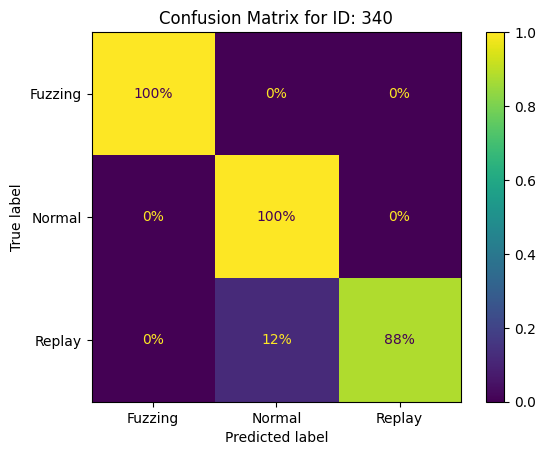

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       201
      Normal       1.00      1.00      1.00     25658
      Replay       0.99      0.96      0.98       410

    accuracy                           1.00     26269
   macro avg       1.00      0.99      0.99     26269
weighted avg       1.00      1.00      1.00     26269



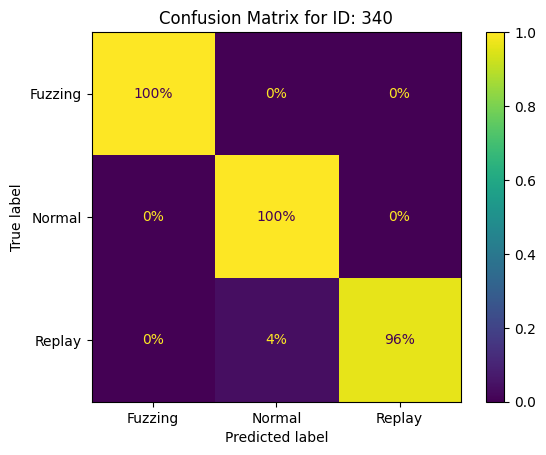

<Figure size 800x600 with 0 Axes>



Result 340 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          340  0.997944  0.997925  0.997944  0.997887
XGBoost                340  0.999353  0.999351  0.999353  0.999348


Processing ID: 260
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       416
      Normal       1.00      1.00      1.00     25662
      Replay       1.00      1.00      1.00       372

    accuracy                           1.00     26450
   macro avg       1.00      1.00      1.00     26450
weighted avg       1.00      1.00      1.00     26450



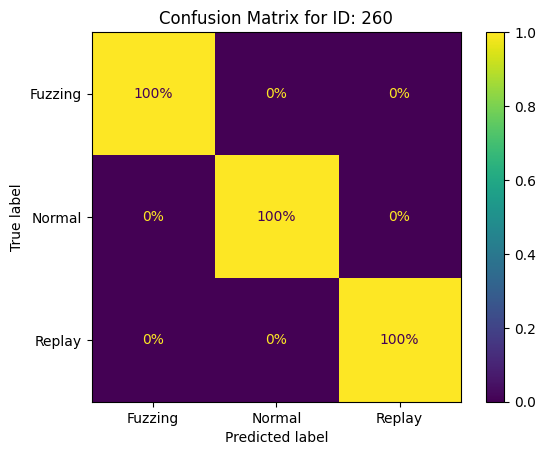

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       416
      Normal       1.00      1.00      1.00     25662
      Replay       1.00      1.00      1.00       372

    accuracy                           1.00     26450
   macro avg       1.00      1.00      1.00     26450
weighted avg       1.00      1.00      1.00     26450



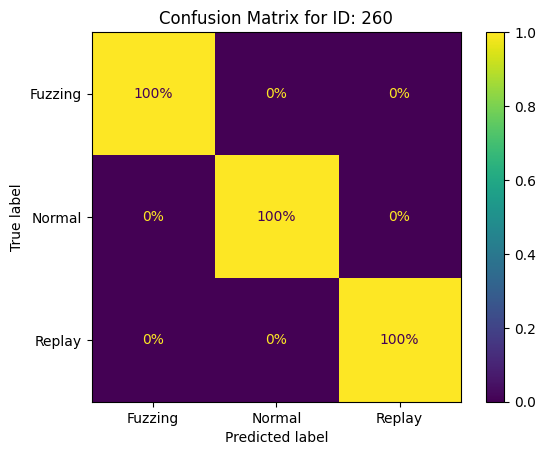

<Figure size 800x600 with 0 Axes>



Result 260 models:

              ProcessingID Accuracy Precision Recall F1 Score
Random Forest          260      1.0       1.0    1.0      1.0
XGBoost                260      1.0       1.0    1.0      1.0


Processing ID: 47F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       216
      Normal       1.00      1.00      1.00     12818
      Replay       0.98      0.73      0.84       204

    accuracy                           1.00     13238
   macro avg       0.99      0.91      0.94     13238
weighted avg       1.00      1.00      1.00     13238



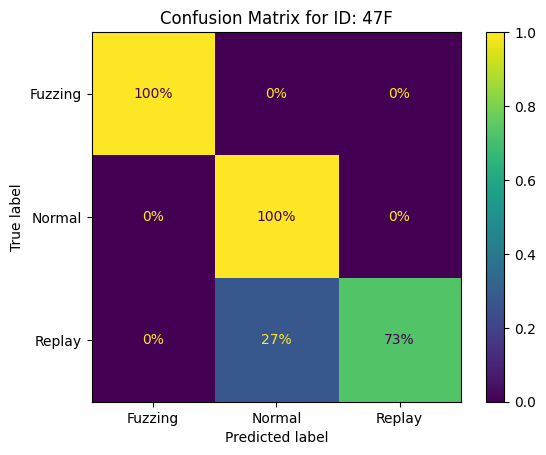

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       216
      Normal       1.00      1.00      1.00     12818
      Replay       0.98      0.95      0.96       204

    accuracy                           1.00     13238
   macro avg       0.99      0.98      0.99     13238
weighted avg       1.00      1.00      1.00     13238



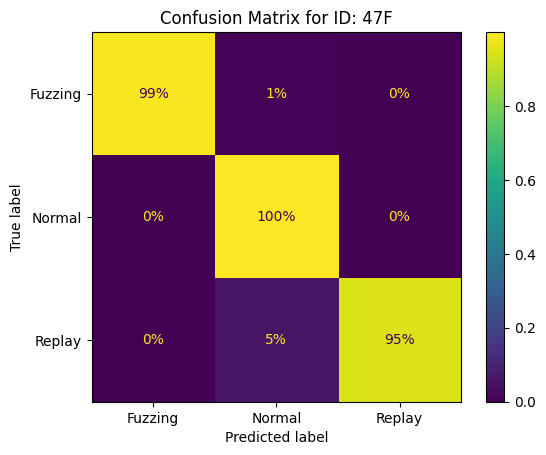

<Figure size 800x600 with 0 Axes>



Result 47F models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          47F  0.995619  0.995558  0.995619  0.995303
XGBoost                47F  0.998716  0.998706  0.998716  0.998706


Processing ID: 329
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       209
      Normal       1.00      1.00      1.00     25643
      Replay       1.00      0.80      0.89       414

    accuracy                           1.00     26266
   macro avg       1.00      0.93      0.96     26266
weighted avg       1.00      1.00      1.00     26266



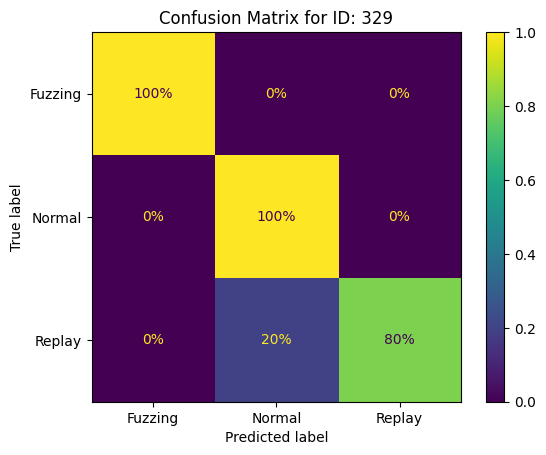

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       209
      Normal       1.00      1.00      1.00     25643
      Replay       1.00      0.99      1.00       414

    accuracy                           1.00     26266
   macro avg       1.00      1.00      1.00     26266
weighted avg       1.00      1.00      1.00     26266



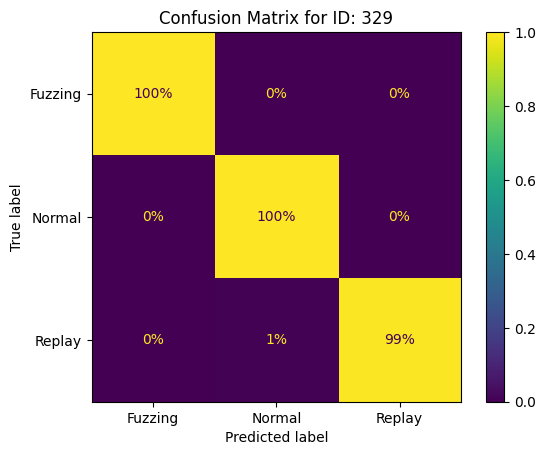

<Figure size 800x600 with 0 Axes>



Result 329 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          329  0.996916  0.996926  0.996916  0.996751
XGBoost                329  0.999886  0.999886  0.999886  0.999886


Processing ID: 164
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       423
      Normal       1.00      1.00      1.00     25633
      Replay       1.00      0.88      0.93       387

    accuracy                           1.00     26443
   macro avg       1.00      0.96      0.98     26443
weighted avg       1.00      1.00      1.00     26443



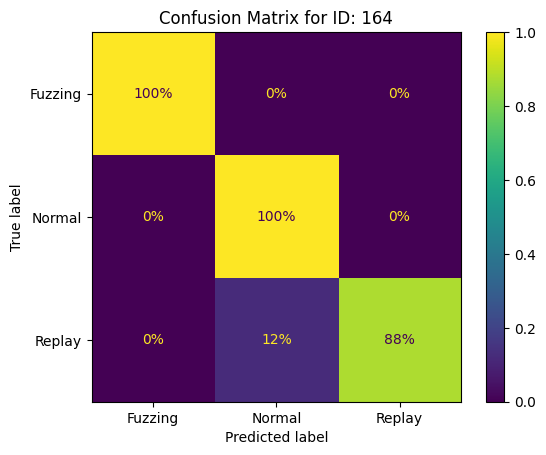

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       423
      Normal       1.00      1.00      1.00     25633
      Replay       0.98      0.97      0.97       387

    accuracy                           1.00     26443
   macro avg       0.99      0.99      0.99     26443
weighted avg       1.00      1.00      1.00     26443



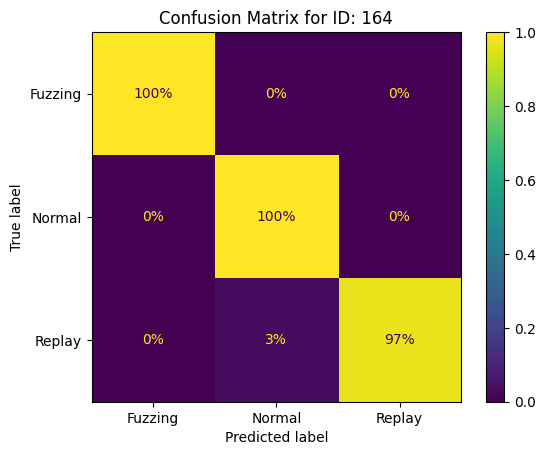

<Figure size 800x600 with 0 Axes>



Result 164 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          164  0.998147  0.998145  0.998147  0.998088
XGBoost                164  0.999244   0.99924  0.999244  0.999241


Processing ID: 387
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       228
      Normal       1.00      1.00      1.00     12797
      Replay       1.00      0.85      0.92       217

    accuracy                           1.00     13242
   macro avg       1.00      0.95      0.97     13242
weighted avg       1.00      1.00      1.00     13242



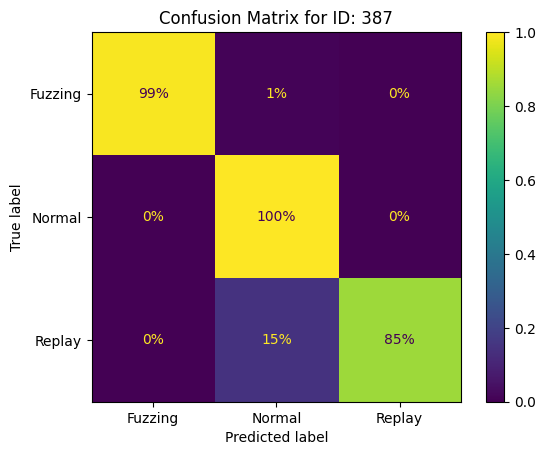

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.97      0.99       228
      Normal       1.00      1.00      1.00     12797
      Replay       1.00      0.98      0.99       217

    accuracy                           1.00     13242
   macro avg       1.00      0.99      0.99     13242
weighted avg       1.00      1.00      1.00     13242



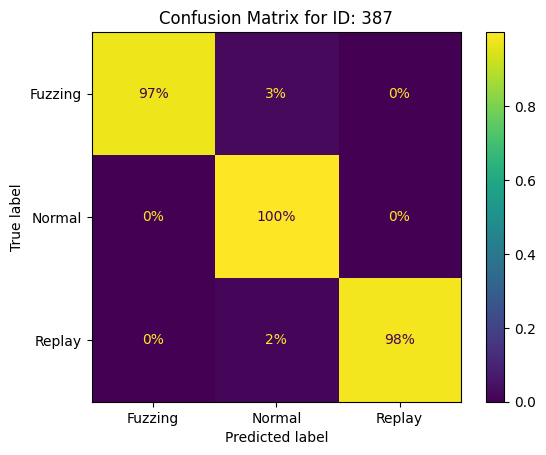

<Figure size 800x600 with 0 Axes>



Result 387 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          387  0.997432  0.997439  0.997432  0.997338
XGBoost                387  0.999169  0.999169  0.999169  0.999165


Processing ID: 394
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       183
      Normal       1.00      1.00      1.00     12855
      Replay       1.00      0.91      0.96       187

    accuracy                           1.00     13225
   macro avg       1.00      0.97      0.98     13225
weighted avg       1.00      1.00      1.00     13225



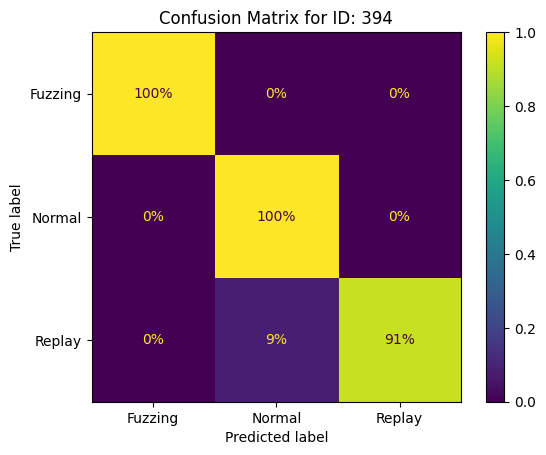

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       183
      Normal       1.00      1.00      1.00     12855
      Replay       1.00      0.97      0.98       187

    accuracy                           1.00     13225
   macro avg       1.00      0.99      0.99     13225
weighted avg       1.00      1.00      1.00     13225



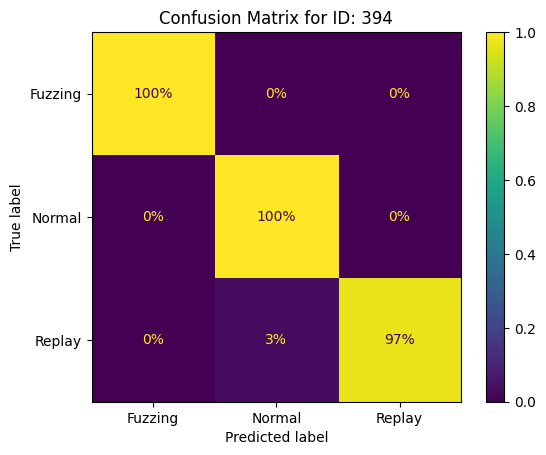

<Figure size 800x600 with 0 Axes>



Result 394 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          394   0.99879  0.998792   0.99879  0.998764
XGBoost                394  0.999546  0.999547  0.999546  0.999543


Processing ID: 4F1
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       217
      Normal       1.00      1.00      1.00     12804
      Replay       1.00      0.86      0.93       195

    accuracy                           1.00     13216
   macro avg       1.00      0.95      0.97     13216
weighted avg       1.00      1.00      1.00     13216



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       217
      Normal       1.00      1.00      1.00     12804
      Replay       0.98      0.99      0.99       195

    accuracy                           1.00     13216
   macro avg       0.99      1.00      1.00     13216
weighted avg       1.00      1.00      1.00     13216



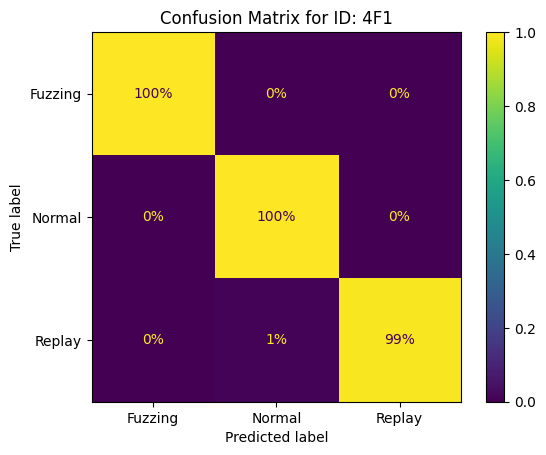

<Figure size 800x600 with 0 Axes>



Result 4F1 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          4F1  0.997957  0.997961  0.997957  0.997882
XGBoost                4F1  0.999622  0.999623  0.999622  0.999622


Processing ID: 130
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       394
      Normal       1.00      1.00      1.00     25653
      Replay       1.00      0.94      0.97       403

    accuracy                           1.00     26450
   macro avg       1.00      0.98      0.99     26450
weighted avg       1.00      1.00      1.00     26450



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       394
      Normal       1.00      1.00      1.00     25653
      Replay       1.00      0.98      0.99       403

    accuracy                           1.00     26450
   macro avg       1.00      0.99      1.00     26450
weighted avg       1.00      1.00      1.00     26450



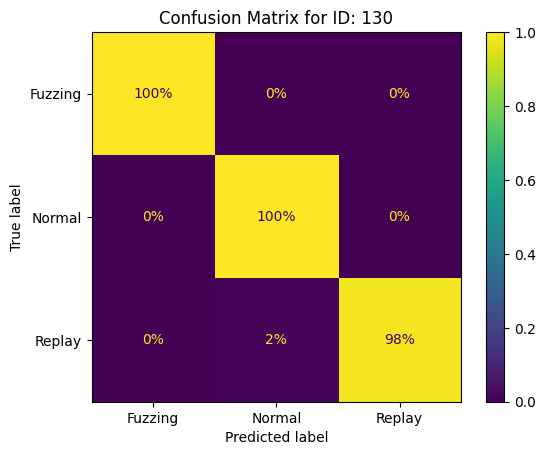

<Figure size 800x600 with 0 Axes>



Result 130 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          130  0.999017  0.999018  0.999017  0.999001
XGBoost                130  0.999698  0.999698  0.999698  0.999696


Processing ID: 140
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       429
      Normal       1.00      1.00      1.00     25648
      Replay       0.99      0.97      0.98       372

    accuracy                           1.00     26449
   macro avg       1.00      0.99      0.99     26449
weighted avg       1.00      1.00      1.00     26449



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       429
      Normal       1.00      1.00      1.00     25648
      Replay       1.00      0.99      0.99       372

    accuracy                           1.00     26449
   macro avg       1.00      1.00      1.00     26449
weighted avg       1.00      1.00      1.00     26449



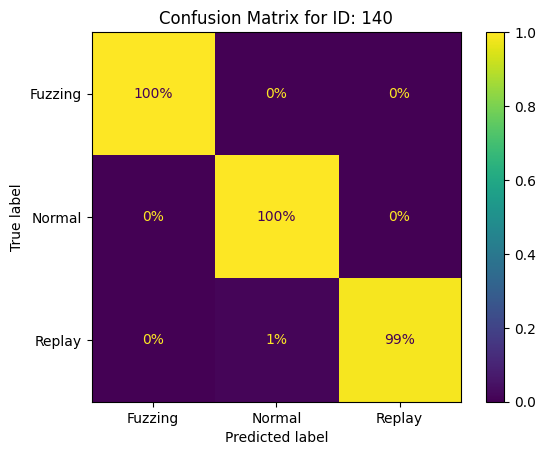

<Figure size 800x600 with 0 Axes>



Result 140 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          140  0.999508  0.999507  0.999508  0.999506
XGBoost                140  0.999773  0.999773  0.999773  0.999773


Processing ID: 356
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.98      0.65      0.78       215
      Normal       0.99      1.00      1.00     25662
      Replay       0.94      0.78      0.85       396

    accuracy                           0.99     26273
   macro avg       0.97      0.81      0.88     26273
weighted avg       0.99      0.99      0.99     26273



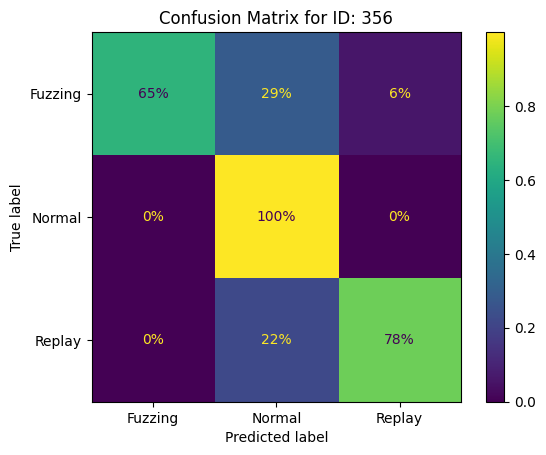

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.97      0.81      0.88       215
      Normal       1.00      1.00      1.00     25662
      Replay       0.95      0.88      0.92       396

    accuracy                           1.00     26273
   macro avg       0.97      0.90      0.93     26273
weighted avg       1.00      1.00      1.00     26273



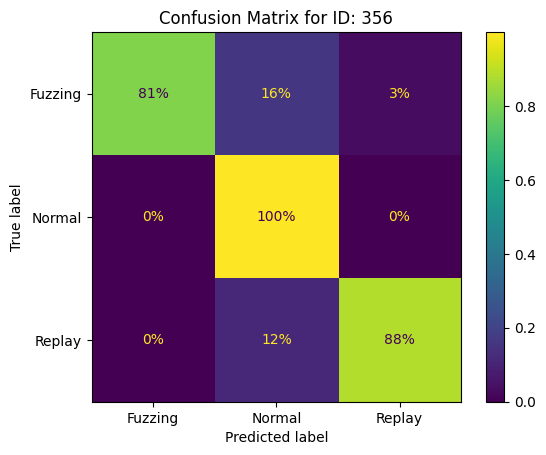

<Figure size 800x600 with 0 Axes>



Result 356 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          356  0.993491  0.993318  0.993491  0.993006
XGBoost                356   0.99608  0.995997   0.99608  0.995957


Processing ID: 153
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       431
      Normal       1.00      1.00      1.00     25631
      Replay       1.00      0.90      0.95       413

    accuracy                           1.00     26475
   macro avg       1.00      0.97      0.98     26475
weighted avg       1.00      1.00      1.00     26475



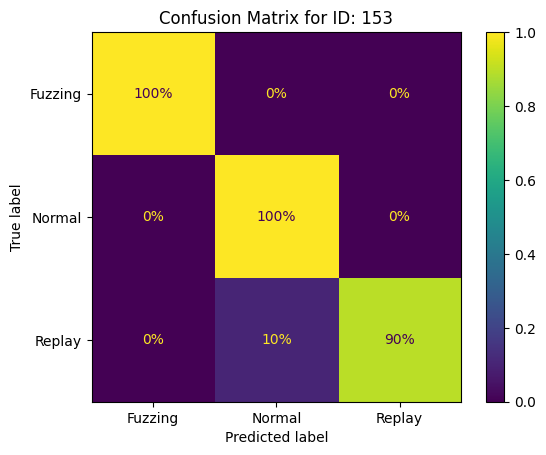

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       431
      Normal       1.00      1.00      1.00     25631
      Replay       0.98      0.97      0.97       413

    accuracy                           1.00     26475
   macro avg       0.99      0.99      0.99     26475
weighted avg       1.00      1.00      1.00     26475



<Figure size 800x600 with 0 Axes>



Result 153 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          153  0.998376  0.998374  0.998376  0.998334
XGBoost                153  0.999207  0.999202  0.999207  0.999203


Processing ID: 220
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       453
      Normal       1.00      1.00      1.00     25630
      Replay       0.99      0.91      0.95       398

    accuracy                           1.00     26481
   macro avg       1.00      0.97      0.98     26481
weighted avg       1.00      1.00      1.00     26481



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       453
      Normal       1.00      1.00      1.00     25630
      Replay       0.99      0.97      0.98       398

    accuracy                           1.00     26481
   macro avg       1.00      0.99      0.99     26481
weighted avg       1.00      1.00      1.00     26481



<Figure size 800x600 with 0 Axes>



Result 220 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          220  0.998489  0.998481  0.998489   0.99846
XGBoost                220  0.999471   0.99947  0.999471  0.999469


Processing ID: 366
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       213
      Normal       1.00      1.00      1.00     25594
      Replay       1.00      0.83      0.91       424
    Spoofing       1.00      1.00      1.00       803

    accuracy                           1.00     27034
   macro avg       1.00      0.96      0.98     27034
weighted avg       1.00      1.00      1.00     27034



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       213
      Normal       1.00      1.00      1.00     25594
      Replay       1.00      0.99      0.99       424
    Spoofing       1.00      1.00      1.00       803

    accuracy                           1.00     27034
   macro avg       1.00      1.00      1.00     27034
weighted avg       1.00      1.00      1.00     27034



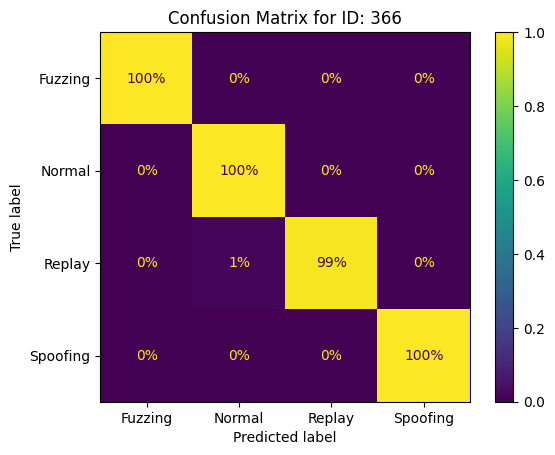

<Figure size 800x600 with 0 Axes>



Result 366 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          366  0.997337  0.997337  0.997337  0.997219
XGBoost                366  0.999778  0.999778  0.999778  0.999777


Processing ID: 367
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.95      0.97       199
      Normal       1.00      1.00      1.00     25674
      Replay       0.98      0.76      0.86       373

    accuracy                           1.00     26246
   macro avg       0.99      0.90      0.94     26246
weighted avg       1.00      1.00      1.00     26246



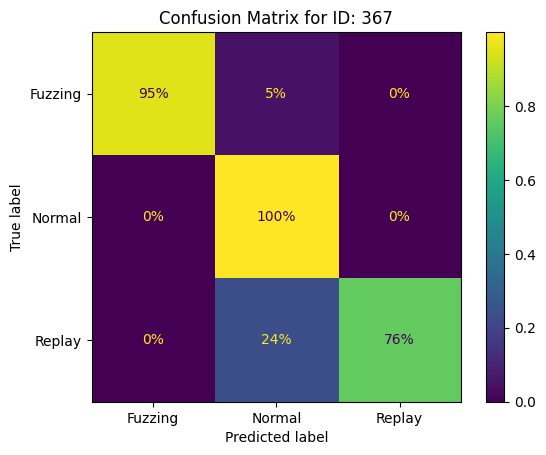

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.99      0.99       199
      Normal       1.00      1.00      1.00     25674
      Replay       0.97      0.94      0.95       373

    accuracy                           1.00     26246
   macro avg       0.99      0.98      0.98     26246
weighted avg       1.00      1.00      1.00     26246



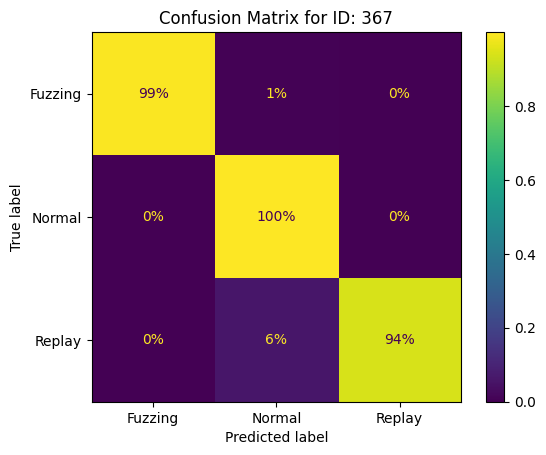

<Figure size 800x600 with 0 Axes>



Result 367 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          367  0.995923   0.99586  0.995923  0.995696
XGBoost                367  0.998666  0.998653  0.998666  0.998655


Processing ID: 368
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       223
      Normal       1.00      1.00      1.00     25611
      Replay       1.00      0.90      0.95       414

    accuracy                           1.00     26248
   macro avg       1.00      0.97      0.98     26248
weighted avg       1.00      1.00      1.00     26248



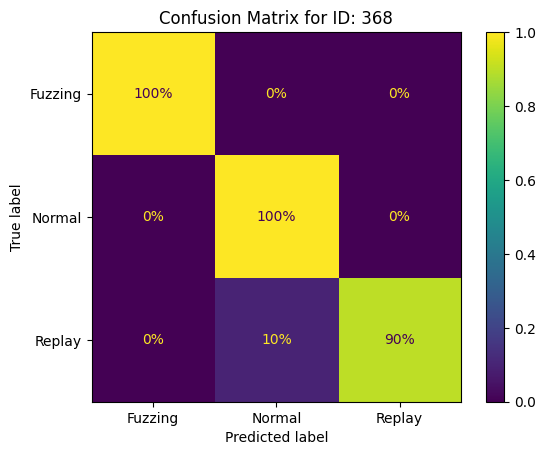

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       223
      Normal       1.00      1.00      1.00     25611
      Replay       1.00      0.99      1.00       414

    accuracy                           1.00     26248
   macro avg       1.00      1.00      1.00     26248
weighted avg       1.00      1.00      1.00     26248



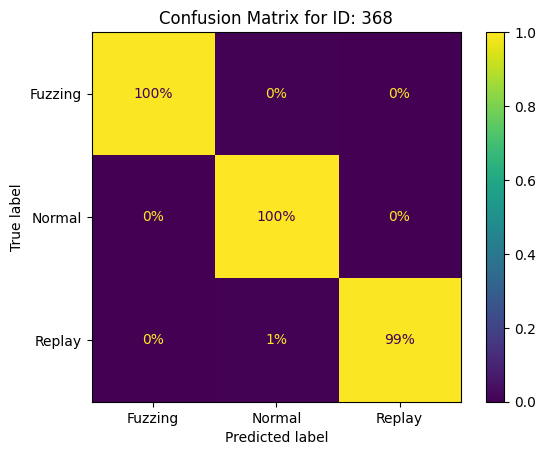

<Figure size 800x600 with 0 Axes>



Result 368 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          368    0.9984  0.998398    0.9984   0.99836
XGBoost                368  0.999848  0.999848  0.999848  0.999847


Processing ID: 412
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       205
      Normal       1.00      1.00      1.00      1275
      Replay       1.00      0.89      0.94        18

    accuracy                           1.00      1498
   macro avg       1.00      0.96      0.98      1498
weighted avg       1.00      1.00      1.00      1498



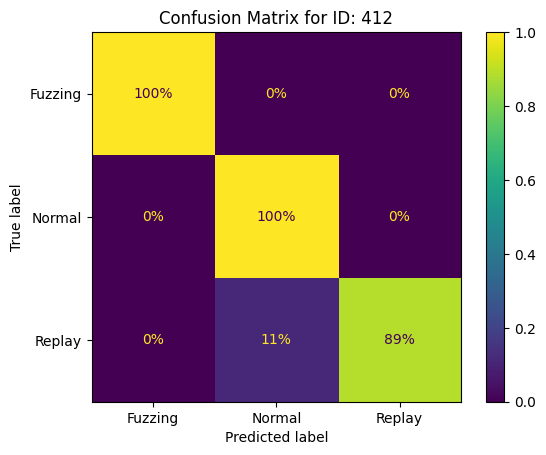

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       205
      Normal       1.00      1.00      1.00      1275
      Replay       1.00      0.89      0.94        18

    accuracy                           1.00      1498
   macro avg       1.00      0.96      0.98      1498
weighted avg       1.00      1.00      1.00      1498



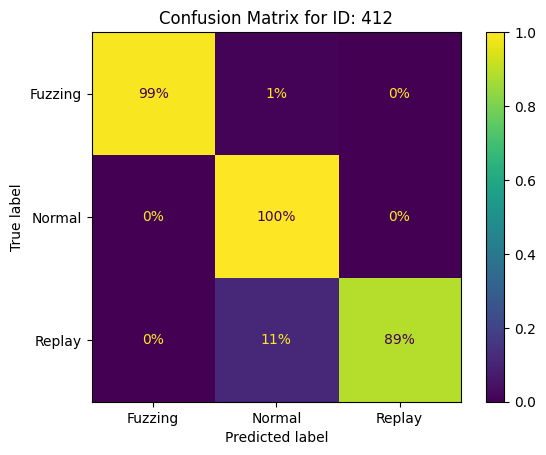

<Figure size 800x600 with 0 Axes>



Result 412 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          412  0.998665  0.998667  0.998665  0.998626
XGBoost                412   0.99733  0.997338   0.99733  0.997289


Processing ID: 470
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.90      0.95       211
      Normal       0.99      1.00      1.00     12786
      Replay       0.95      0.72      0.82       204

    accuracy                           0.99     13201
   macro avg       0.98      0.87      0.92     13201
weighted avg       0.99      0.99      0.99     13201



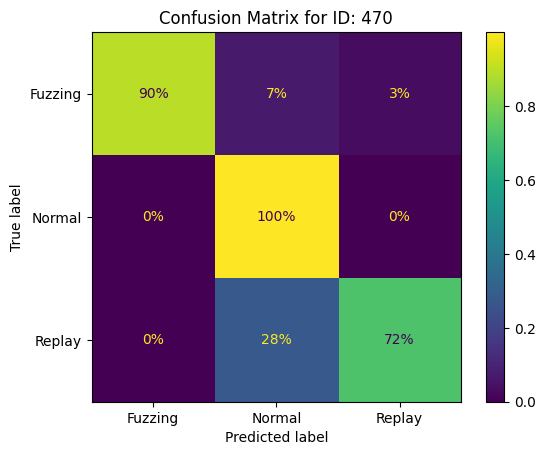

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.97      0.98       211
      Normal       1.00      1.00      1.00     12786
      Replay       0.96      0.87      0.91       204

    accuracy                           1.00     13201
   macro avg       0.98      0.95      0.96     13201
weighted avg       1.00      1.00      1.00     13201



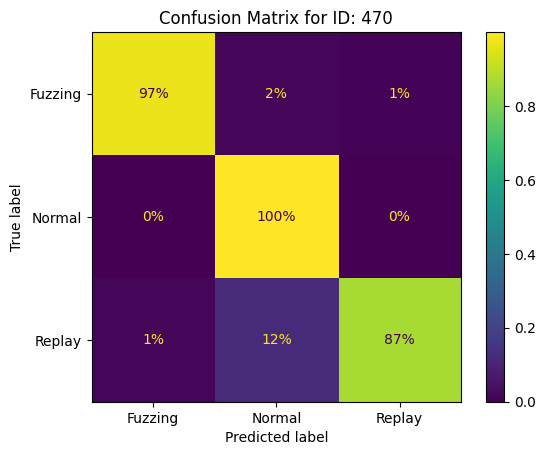

<Figure size 800x600 with 0 Axes>



Result 470 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          470   0.99394  0.993778   0.99394  0.993566
XGBoost                470  0.997121  0.997064  0.997121  0.997054


Processing ID: 38D
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       195
      Normal       1.00      1.00      1.00     12833
      Replay       1.00      0.80      0.89       198

    accuracy                           1.00     13226
   macro avg       1.00      0.93      0.96     13226
weighted avg       1.00      1.00      1.00     13226



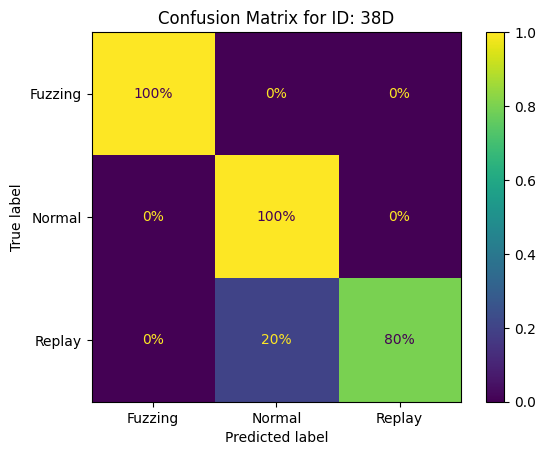

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       195
      Normal       1.00      1.00      1.00     12833
      Replay       0.99      0.94      0.97       198

    accuracy                           1.00     13226
   macro avg       1.00      0.98      0.99     13226
weighted avg       1.00      1.00      1.00     13226



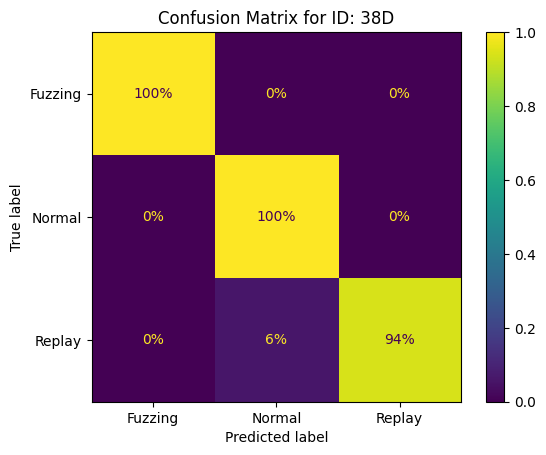

<Figure size 800x600 with 0 Axes>



Result 38D models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          38D  0.996976  0.996985  0.996976  0.996808
XGBoost                38D  0.999017  0.999013  0.999017  0.999003


Processing ID: 420
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       205
      Normal       1.00      1.00      1.00     12819
      Replay       0.97      0.76      0.86       198

    accuracy                           1.00     13222
   macro avg       0.99      0.92      0.95     13222
weighted avg       1.00      1.00      1.00     13222



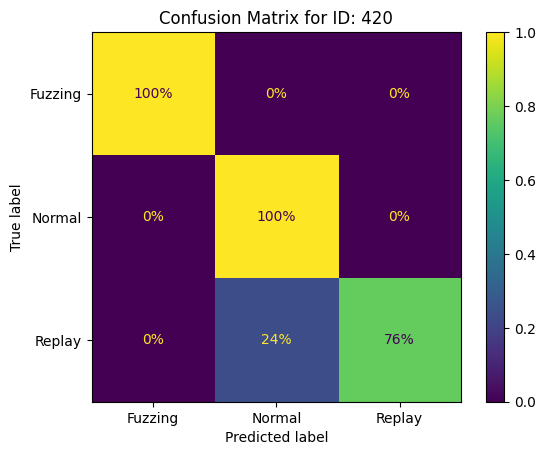

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       205
      Normal       1.00      1.00      1.00     12819
      Replay       0.97      0.90      0.93       198

    accuracy                           1.00     13222
   macro avg       0.99      0.97      0.98     13222
weighted avg       1.00      1.00      1.00     13222



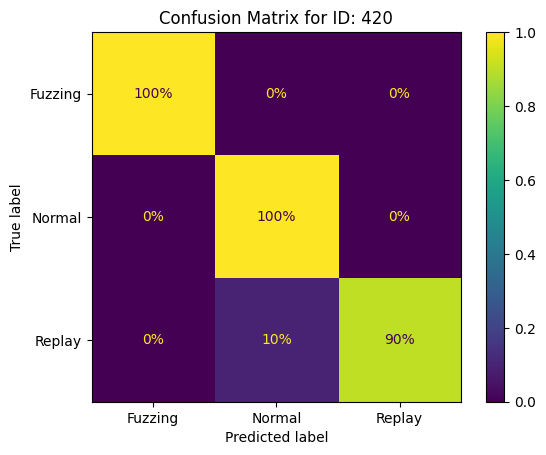

<Figure size 800x600 with 0 Axes>



Result 420 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          420  0.996143  0.996071  0.996143  0.995911
XGBoost                420  0.998109  0.998079  0.998109  0.998078


Processing ID: 421
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       224
      Normal       1.00      1.00      1.00     12811
      Replay       0.98      0.73      0.84       199

    accuracy                           1.00     13234
   macro avg       0.99      0.91      0.94     13234
weighted avg       1.00      1.00      1.00     13234



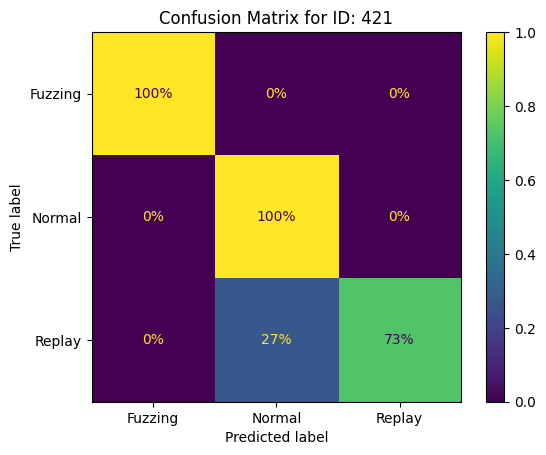

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       224
      Normal       1.00      1.00      1.00     12811
      Replay       0.96      0.91      0.94       199

    accuracy                           1.00     13234
   macro avg       0.99      0.97      0.98     13234
weighted avg       1.00      1.00      1.00     13234



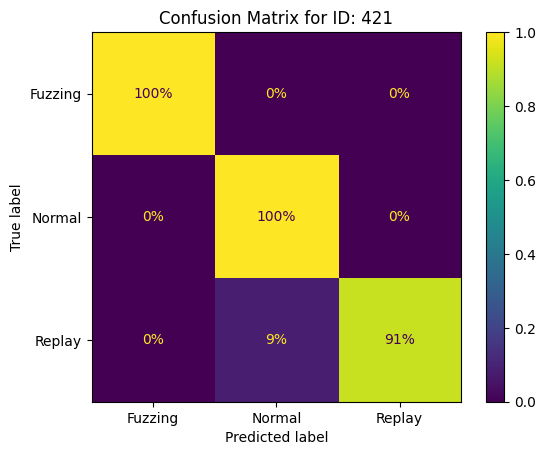

<Figure size 800x600 with 0 Axes>



Result 421 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          421  0.995693  0.995631  0.995693  0.995381
XGBoost                421  0.998186   0.99816  0.998186  0.998163


Processing ID: 389
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       218
      Normal       1.00      1.00      1.00     12811
      Replay       0.99      0.69      0.81       191

    accuracy                           1.00     13220
   macro avg       0.99      0.90      0.94     13220
weighted avg       1.00      1.00      0.99     13220



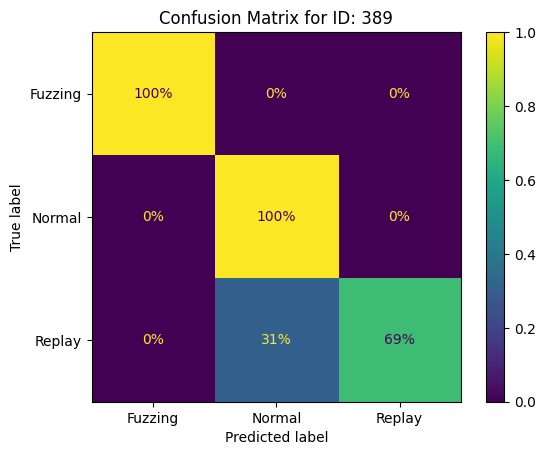

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       218
      Normal       1.00      1.00      1.00     12811
      Replay       0.95      0.82      0.88       191

    accuracy                           1.00     13220
   macro avg       0.98      0.94      0.96     13220
weighted avg       1.00      1.00      1.00     13220



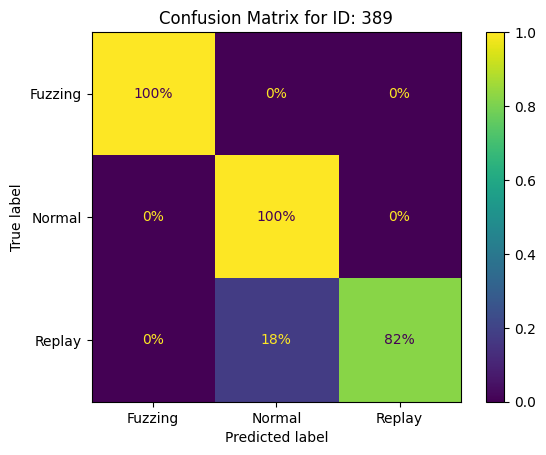

<Figure size 800x600 with 0 Axes>



Result 389 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          389  0.995386  0.995341  0.995386  0.994986
XGBoost                389  0.996747   0.99665  0.996747  0.996635


Processing ID: 386
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00     12839
      Replay       1.00      0.93      0.96       194

    accuracy                           1.00     13236
   macro avg       1.00      0.98      0.99     13236
weighted avg       1.00      1.00      1.00     13236



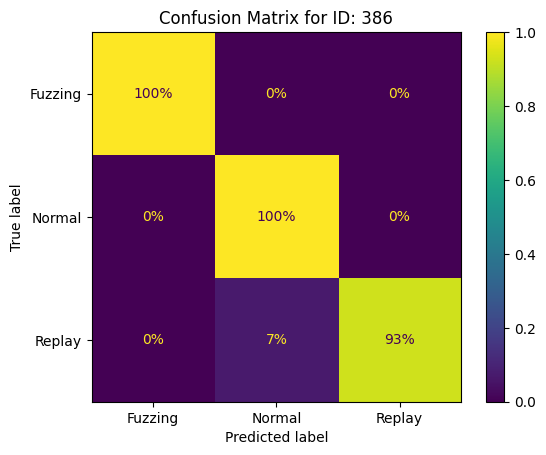

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00     12839
      Replay       1.00      0.95      0.97       194

    accuracy                           1.00     13236
   macro avg       1.00      0.98      0.99     13236
weighted avg       1.00      1.00      1.00     13236



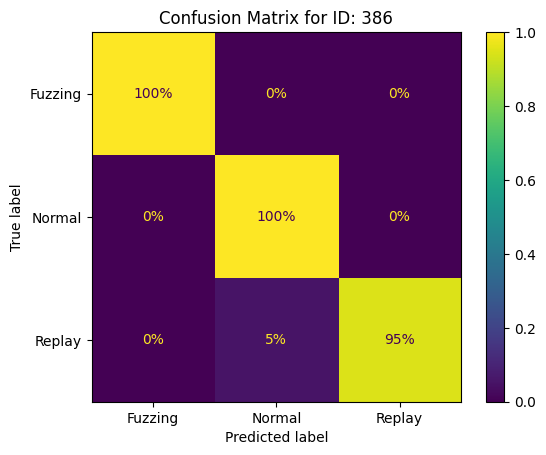

<Figure size 800x600 with 0 Axes>



Result 386 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          386  0.998942  0.998943  0.998942  0.998923
XGBoost                386  0.999244  0.999245  0.999244  0.999235


Processing ID: 492
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       205
      Normal       1.00      1.00      1.00      5135
      Replay       0.98      0.80      0.88        70

    accuracy                           1.00      5410
   macro avg       0.99      0.93      0.96      5410
weighted avg       1.00      1.00      1.00      5410



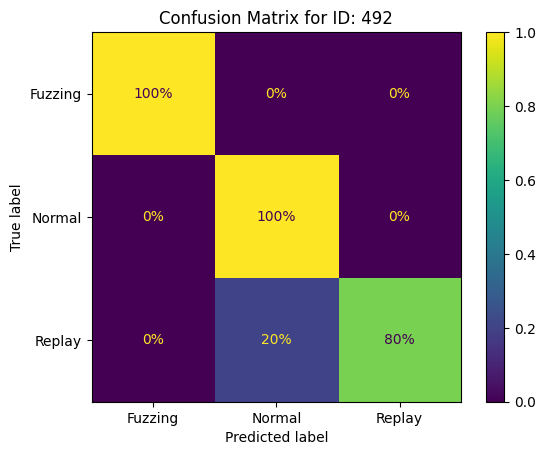

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       205
      Normal       1.00      1.00      1.00      5135
      Replay       0.97      0.93      0.95        70

    accuracy                           1.00      5410
   macro avg       0.99      0.98      0.98      5410
weighted avg       1.00      1.00      1.00      5410



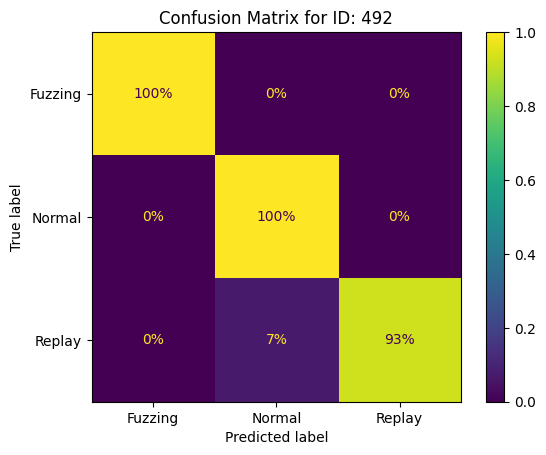

<Figure size 800x600 with 0 Axes>



Result 492 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          492  0.997227  0.997192  0.997227  0.997087
XGBoost                492  0.998706   0.99869  0.998706  0.998692


Processing ID: 391
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.94      0.97       226
      Normal       1.00      1.00      1.00     12788
      Replay       0.97      0.83      0.90       205

    accuracy                           1.00     13219
   macro avg       0.99      0.93      0.95     13219
weighted avg       1.00      1.00      1.00     13219



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.97      0.98       226
      Normal       1.00      1.00      1.00     12788
      Replay       0.97      0.93      0.95       205

    accuracy                           1.00     13219
   macro avg       0.99      0.97      0.98     13219
weighted avg       1.00      1.00      1.00     13219



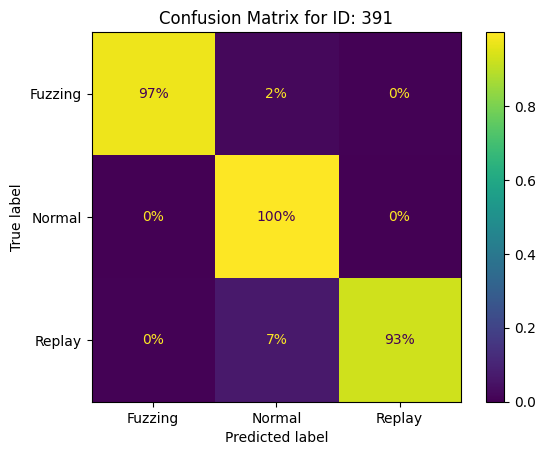

<Figure size 800x600 with 0 Axes>



Result 391 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          391  0.996369  0.996307  0.996369  0.996246
XGBoost                391  0.998033  0.998012  0.998033  0.998013


Processing ID: 485
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       219
      Normal       1.00      1.00      1.00      5113
      Replay       1.00      0.82      0.90        85

    accuracy                           1.00      5417
   macro avg       1.00      0.94      0.97      5417
weighted avg       1.00      1.00      1.00      5417



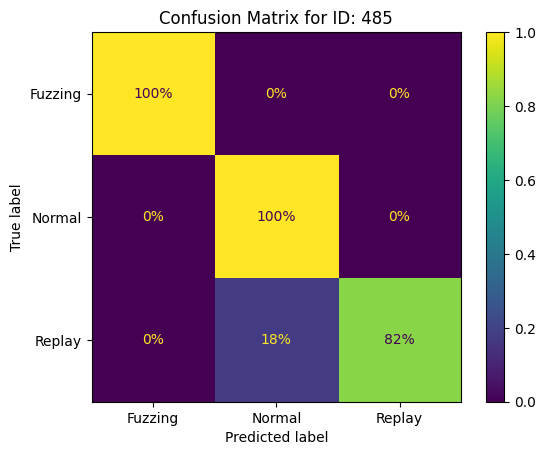

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       219
      Normal       1.00      1.00      1.00      5113
      Replay       0.98      0.94      0.96        85

    accuracy                           1.00      5417
   macro avg       0.99      0.98      0.99      5417
weighted avg       1.00      1.00      1.00      5417



<Figure size 800x600 with 0 Axes>



Result 485 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          485  0.997231  0.997239  0.997231  0.997099
XGBoost                485  0.998708  0.998695  0.998708  0.998696


Processing ID: 490
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       235
      Normal       1.00      1.00      1.00      5121
      Replay       1.00      0.86      0.92        71

    accuracy                           1.00      5427
   macro avg       1.00      0.95      0.97      5427
weighted avg       1.00      1.00      1.00      5427



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       235
      Normal       1.00      1.00      1.00      5121
      Replay       0.99      0.97      0.98        71

    accuracy                           1.00      5427
   macro avg       1.00      0.99      0.99      5427
weighted avg       1.00      1.00      1.00      5427



<Figure size 800x600 with 0 Axes>



Result 490 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          490  0.998157  0.998161  0.998157  0.998088
XGBoost                490  0.999263  0.999261  0.999263  0.999261


Processing ID: 593
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       211
      Normal       1.00      1.00      1.00      1283
      Replay       1.00      0.95      0.98        22

    accuracy                           1.00      1516
   macro avg       1.00      0.98      0.99      1516
weighted avg       1.00      1.00      1.00      1516



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       211
      Normal       1.00      1.00      1.00      1283
      Replay       1.00      0.95      0.98        22

    accuracy                           1.00      1516
   macro avg       1.00      0.98      0.99      1516
weighted avg       1.00      1.00      1.00      1516



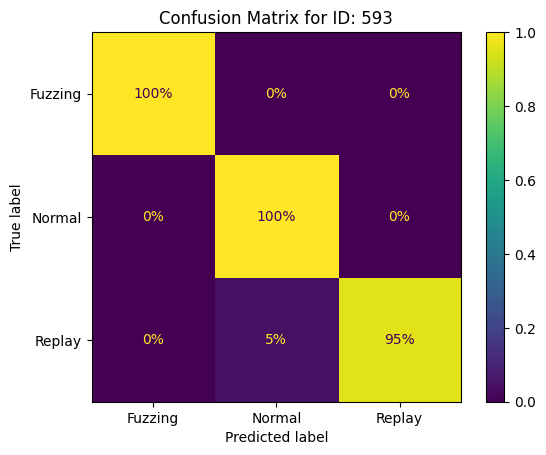

<Figure size 800x600 with 0 Axes>



Result 593 models:

              ProcessingID Accuracy Precision   Recall  F1 Score
Random Forest          593  0.99934  0.999341  0.99934  0.999333
XGBoost                593  0.99934  0.999341  0.99934  0.999333


Processing ID: 484
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       208
      Normal       1.00      1.00      1.00      3653
      Replay       1.00      0.95      0.98        62

    accuracy                           1.00      3923
   macro avg       1.00      0.98      0.99      3923
weighted avg       1.00      1.00      1.00      3923



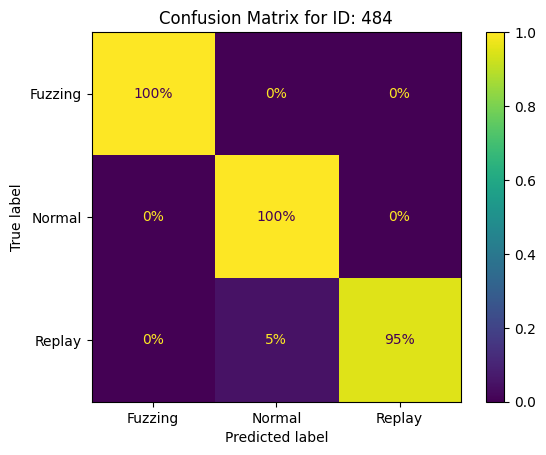

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       208
      Normal       1.00      1.00      1.00      3653
      Replay       0.97      1.00      0.98        62

    accuracy                           1.00      3923
   macro avg       0.99      1.00      0.99      3923
weighted avg       1.00      1.00      1.00      3923



<Figure size 800x600 with 0 Axes>



Result 484 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          484  0.999235  0.999236  0.999235  0.999226
XGBoost                484  0.999235  0.999251  0.999235  0.999237


Processing ID: 48A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       234
      Normal       1.00      1.00      1.00      5113
      Replay       1.00      0.91      0.95        78

    accuracy                           1.00      5425
   macro avg       1.00      0.96      0.98      5425
weighted avg       1.00      1.00      1.00      5425



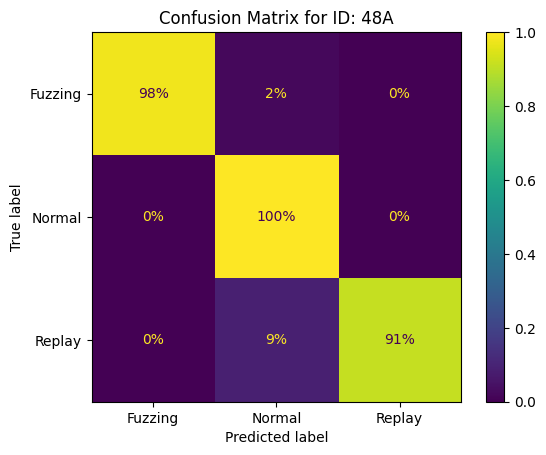

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       234
      Normal       1.00      1.00      1.00      5113
      Replay       1.00      0.96      0.98        78

    accuracy                           1.00      5425
   macro avg       1.00      0.98      0.99      5425
weighted avg       1.00      1.00      1.00      5425



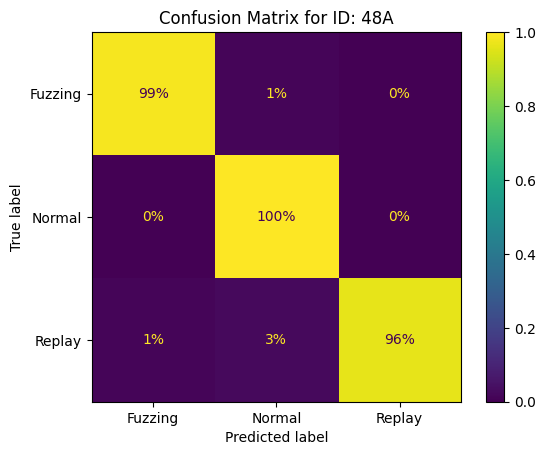

<Figure size 800x600 with 0 Axes>



Result 48A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          48A  0.997788  0.997793  0.997788  0.997754
XGBoost                48A  0.998894  0.998893  0.998894  0.998887


Processing ID: 50C
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       207
      Normal       1.00      1.00      1.00      2554
      Replay       1.00      0.98      0.99        47

    accuracy                           1.00      2808
   macro avg       1.00      0.99      1.00      2808
weighted avg       1.00      1.00      1.00      2808



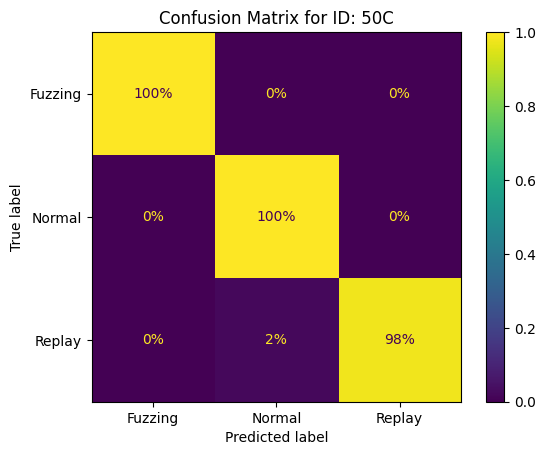

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       207
      Normal       1.00      1.00      1.00      2554
      Replay       1.00      1.00      1.00        47

    accuracy                           1.00      2808
   macro avg       1.00      1.00      1.00      2808
weighted avg       1.00      1.00      1.00      2808



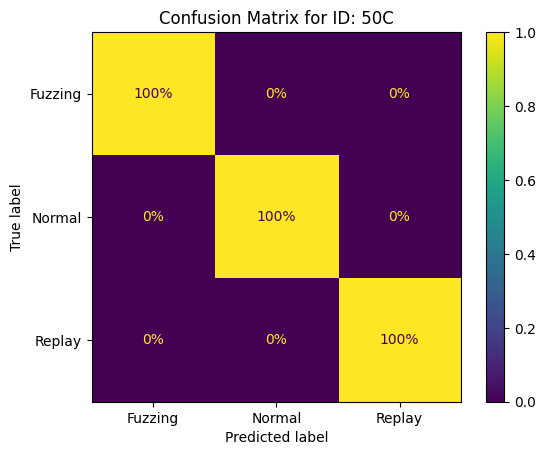

<Figure size 800x600 with 0 Axes>



Result 50C models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          50C  0.999644  0.999644  0.999644  0.999642
XGBoost                50C       1.0       1.0       1.0       1.0


Processing ID: 58B
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       237
      Normal       1.00      1.00      1.00      5104
      Replay       0.97      0.76      0.85        82

    accuracy                           1.00      5423
   macro avg       0.99      0.92      0.95      5423
weighted avg       1.00      1.00      1.00      5423



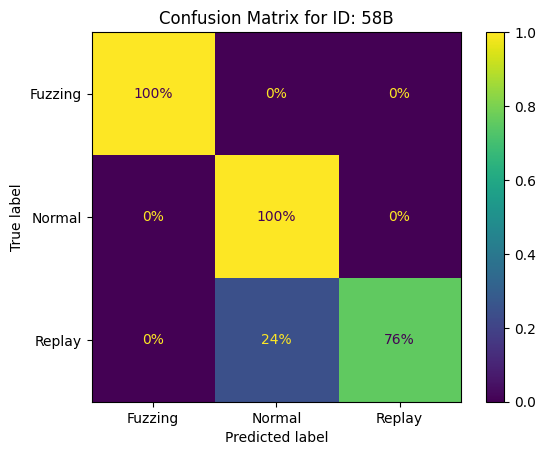

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       237
      Normal       1.00      1.00      1.00      5104
      Replay       0.97      0.94      0.96        82

    accuracy                           1.00      5423
   macro avg       0.99      0.98      0.98      5423
weighted avg       1.00      1.00      1.00      5423



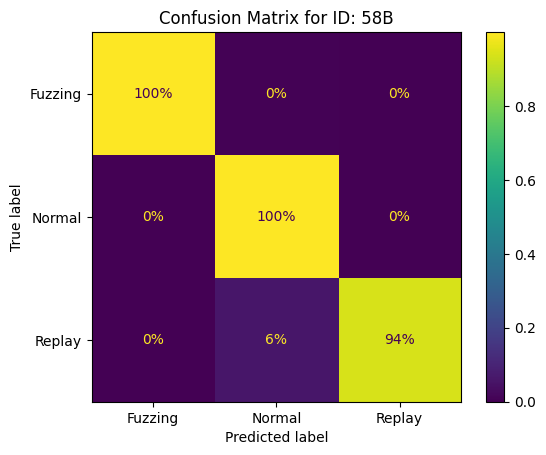

<Figure size 800x600 with 0 Axes>



Result 58B models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          58B  0.995943  0.995852  0.995943  0.995697
XGBoost                58B  0.998525  0.998512  0.998525  0.998513


Processing ID: 436
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       197
      Normal       1.00      1.00      1.00      5119
      Replay       0.97      0.88      0.92        75

    accuracy                           1.00      5391
   macro avg       0.99      0.96      0.97      5391
weighted avg       1.00      1.00      1.00      5391



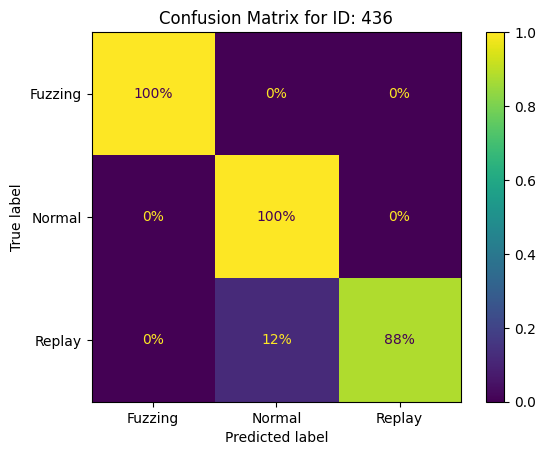

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       197
      Normal       1.00      1.00      1.00      5119
      Replay       0.96      0.97      0.97        75

    accuracy                           1.00      5391
   macro avg       0.99      0.99      0.99      5391
weighted avg       1.00      1.00      1.00      5391



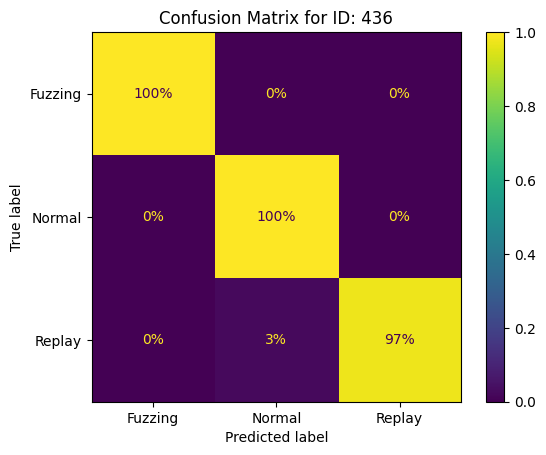

<Figure size 800x600 with 0 Axes>



Result 436 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          436   0.99796  0.997924   0.99796   0.99791
XGBoost                436  0.999073   0.99908  0.999073  0.999076


Processing ID: 541
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       196
      Normal       0.98      1.00      0.99      2741
      Replay       1.00      0.02      0.04        48

    accuracy                           0.98      2985
   macro avg       0.99      0.67      0.68      2985
weighted avg       0.98      0.98      0.98      2985



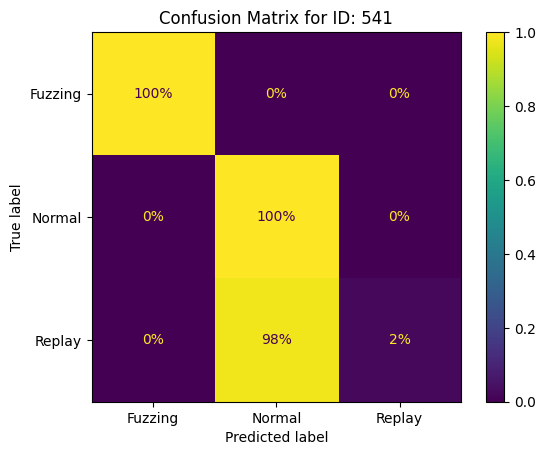

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       196
      Normal       1.00      1.00      1.00      2741
      Replay       1.00      0.96      0.98        48

    accuracy                           1.00      2985
   macro avg       1.00      0.98      0.99      2985
weighted avg       1.00      1.00      1.00      2985



<Figure size 800x600 with 0 Axes>



Result 541 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          541  0.984255   0.98452  0.984255   0.97677
XGBoost                541  0.998325  0.998328  0.998325  0.998315


Processing ID: 507
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       196
      Normal       1.00      1.00      1.00      2572
      Replay       1.00      0.87      0.93        38

    accuracy                           1.00      2806
   macro avg       1.00      0.96      0.98      2806
weighted avg       1.00      1.00      1.00      2806



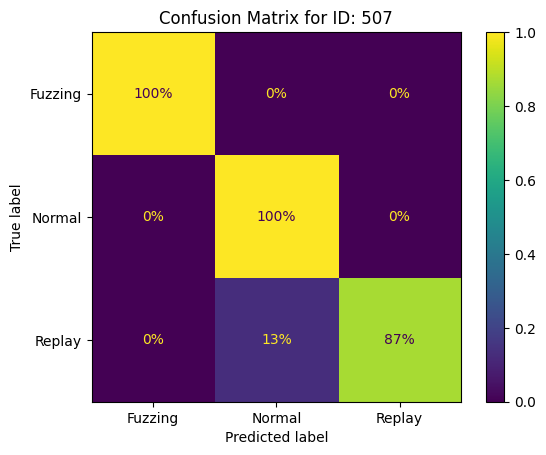

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       196
      Normal       1.00      1.00      1.00      2572
      Replay       1.00      0.92      0.96        38

    accuracy                           1.00      2806
   macro avg       1.00      0.97      0.99      2806
weighted avg       1.00      1.00      1.00      2806



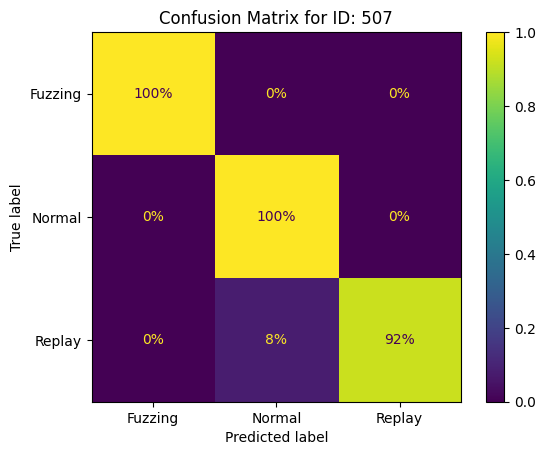

<Figure size 800x600 with 0 Axes>



Result 507 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          507  0.998218  0.998222  0.998218  0.998156
XGBoost                507  0.998931  0.998932  0.998931  0.998909


Processing ID: 4A7
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       195
      Normal       1.00      1.00      1.00       510
      Replay       1.00      0.83      0.91        12

    accuracy                           1.00       717
   macro avg       1.00      0.94      0.97       717
weighted avg       1.00      1.00      1.00       717



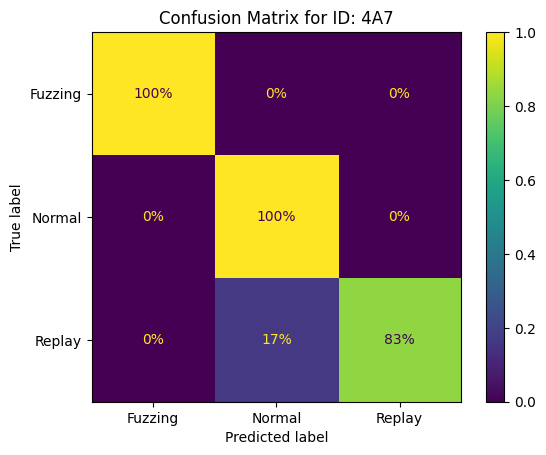

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       195
      Normal       1.00      1.00      1.00       510
      Replay       1.00      0.92      0.96        12

    accuracy                           1.00       717
   macro avg       1.00      0.97      0.99       717
weighted avg       1.00      1.00      1.00       717



<Figure size 800x600 with 0 Axes>



Result 4A7 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          4A7  0.997211  0.997221  0.997211  0.997087
XGBoost                4A7  0.998605  0.998608  0.998605  0.998576


Processing ID: 520
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       208
      Normal       1.00      1.00      1.00      2566
      Replay       1.00      0.93      0.96        40

    accuracy                           1.00      2814
   macro avg       1.00      0.97      0.99      2814
weighted avg       1.00      1.00      1.00      2814



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       208
      Normal       1.00      1.00      1.00      2566
      Replay       0.95      0.95      0.95        40

    accuracy                           1.00      2814
   macro avg       0.98      0.98      0.98      2814
weighted avg       1.00      1.00      1.00      2814



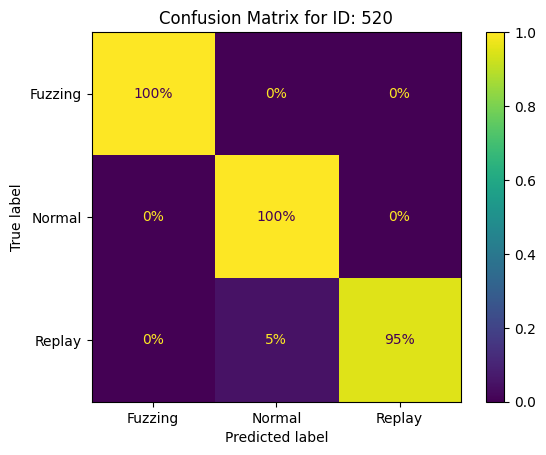

<Figure size 800x600 with 0 Axes>



Result 520 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          520  0.998934  0.998935  0.998934  0.998913
XGBoost                520  0.998579  0.998579  0.998579  0.998579


Processing ID: 53E
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       213
      Normal       1.00      1.00      1.00      2561
      Replay       1.00      0.83      0.91        42

    accuracy                           1.00      2816
   macro avg       1.00      0.94      0.97      2816
weighted avg       1.00      1.00      1.00      2816



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       213
      Normal       1.00      1.00      1.00      2561
      Replay       1.00      0.98      0.99        42

    accuracy                           1.00      2816
   macro avg       1.00      0.99      1.00      2816
weighted avg       1.00      1.00      1.00      2816



<Figure size 800x600 with 0 Axes>



Result 53E models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          53E  0.997514  0.997521  0.997514  0.997403
XGBoost                53E   0.99929   0.99929   0.99929  0.999287


Processing ID: 495
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       180
      Normal       1.00      1.00      1.00      2548
      Replay       1.00      0.90      0.95        48

    accuracy                           1.00      2776
   macro avg       1.00      0.96      0.98      2776
weighted avg       1.00      1.00      1.00      2776



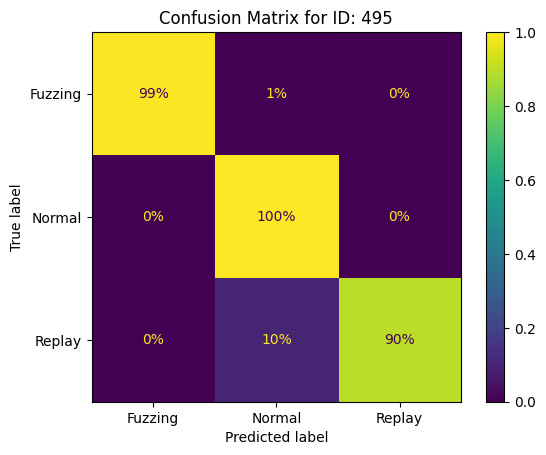

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.98      0.98       180
      Normal       1.00      1.00      1.00      2548
      Replay       1.00      0.92      0.96        48

    accuracy                           1.00      2776
   macro avg       1.00      0.96      0.98      2776
weighted avg       1.00      1.00      1.00      2776



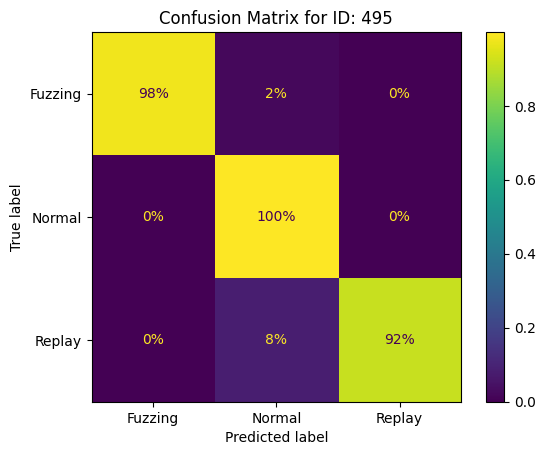

<Figure size 800x600 with 0 Axes>



Result 495 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          495  0.997839  0.997844  0.997839   0.99779
XGBoost                495  0.996398  0.996396  0.996398  0.996362


Processing ID: 500
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       186
      Normal       1.00      1.00      1.00      2554
      Replay       1.00      0.86      0.92        43

    accuracy                           1.00      2783
   macro avg       1.00      0.95      0.97      2783
weighted avg       1.00      1.00      1.00      2783



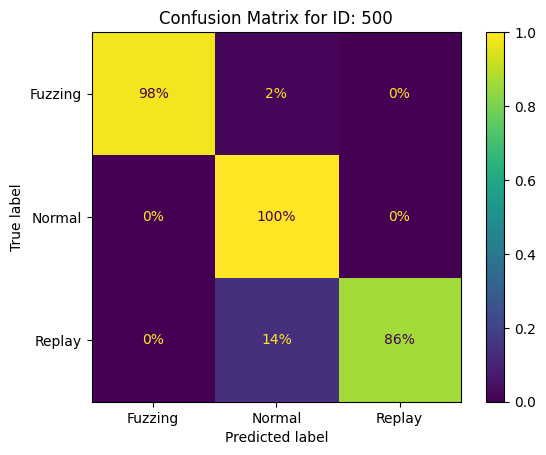

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       186
      Normal       1.00      1.00      1.00      2554
      Replay       0.93      0.93      0.93        43

    accuracy                           1.00      2783
   macro avg       0.98      0.97      0.97      2783
weighted avg       1.00      1.00      1.00      2783



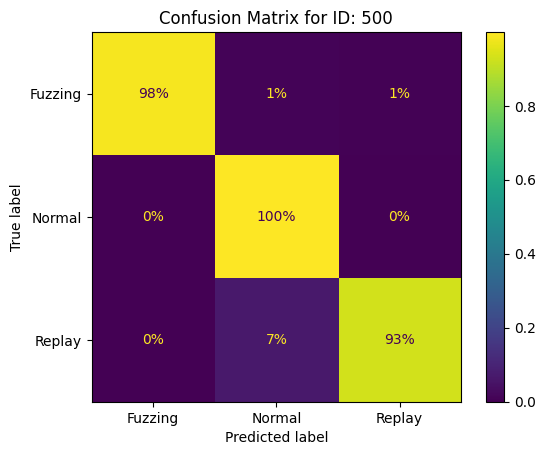

<Figure size 800x600 with 0 Axes>



Result 500 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          500  0.996766  0.996777  0.996766  0.996684
XGBoost                500  0.997125  0.997128  0.997125  0.997122


Processing ID: 483
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.96       192
      Normal       0.99      1.00      0.99      1330
      Replay       0.96      0.88      0.92        26

    accuracy                           0.99      1548
   macro avg       0.98      0.94      0.96      1548
weighted avg       0.99      0.99      0.99      1548



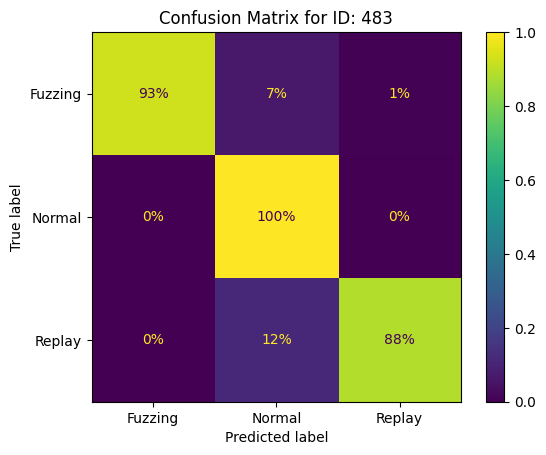

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.97      0.98       192
      Normal       0.99      1.00      1.00      1330
      Replay       1.00      0.85      0.92        26

    accuracy                           0.99      1548
   macro avg       1.00      0.94      0.97      1548
weighted avg       0.99      0.99      0.99      1548



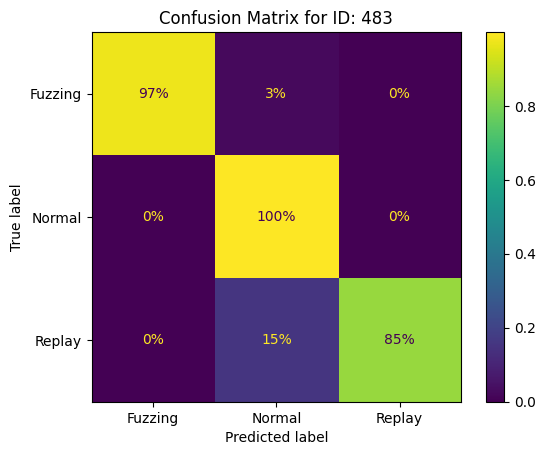

<Figure size 800x600 with 0 Axes>



Result 483 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          483  0.989018  0.989087  0.989018  0.988826
XGBoost                483   0.99354  0.993561   0.99354  0.993422


Processing ID: 4A2
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       215
      Normal       1.00      1.00      1.00       513
      Replay       1.00      0.89      0.94         9

    accuracy                           1.00       737
   macro avg       1.00      0.96      0.98       737
weighted avg       1.00      1.00      1.00       737



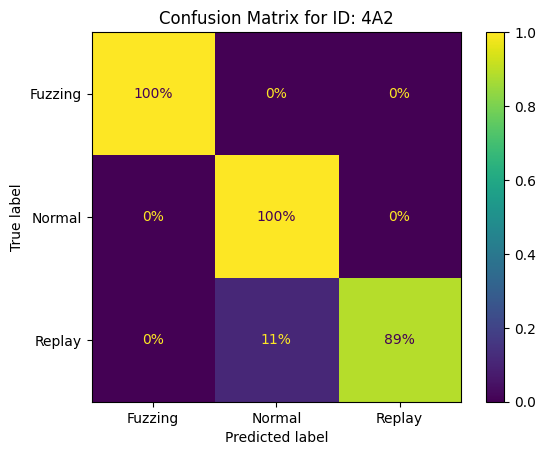

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       215
      Normal       1.00      1.00      1.00       513
      Replay       1.00      1.00      1.00         9

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737



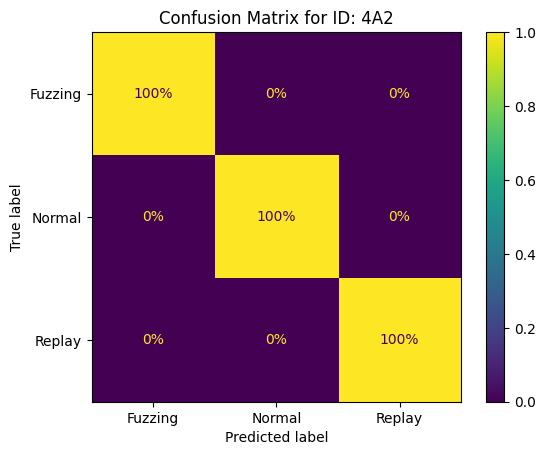

<Figure size 800x600 with 0 Axes>



Result 4A2 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          4A2  0.998643  0.998646  0.998643  0.998604
XGBoost                4A2       1.0       1.0       1.0       1.0


Processing ID: 50A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       212
      Normal       0.99      1.00      0.99      1612
      Replay       1.00      0.12      0.21        17

    accuracy                           0.99      1841
   macro avg       1.00      0.70      0.73      1841
weighted avg       0.99      0.99      0.99      1841



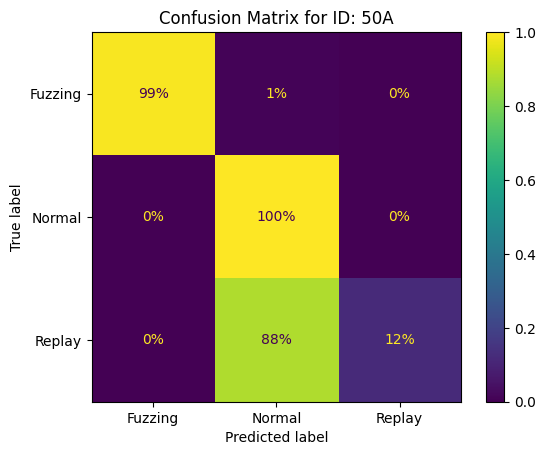

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       212
      Normal       1.00      1.00      1.00      1612
      Replay       0.80      0.71      0.75        17

    accuracy                           0.99      1841
   macro avg       0.93      0.90      0.91      1841
weighted avg       0.99      0.99      0.99      1841



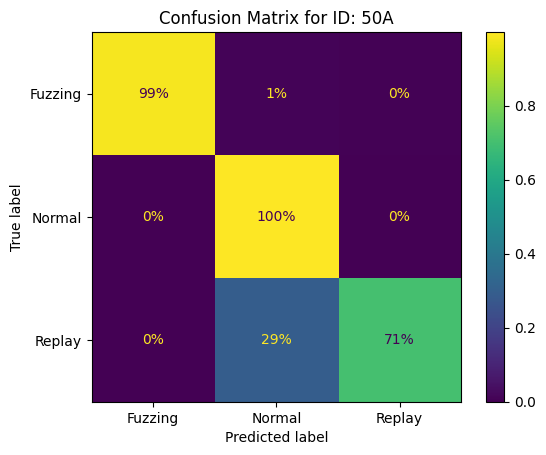

<Figure size 800x600 with 0 Axes>



Result 50A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          50A  0.990766  0.990862  0.990766  0.987571
XGBoost                50A  0.994568  0.994363  0.994568   0.99443


Processing ID: 043
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       414
      Normal       1.00      1.00      1.00       243
      Replay       1.00      1.00      1.00         4

    accuracy                           1.00       661
   macro avg       1.00      1.00      1.00       661
weighted avg       1.00      1.00      1.00       661



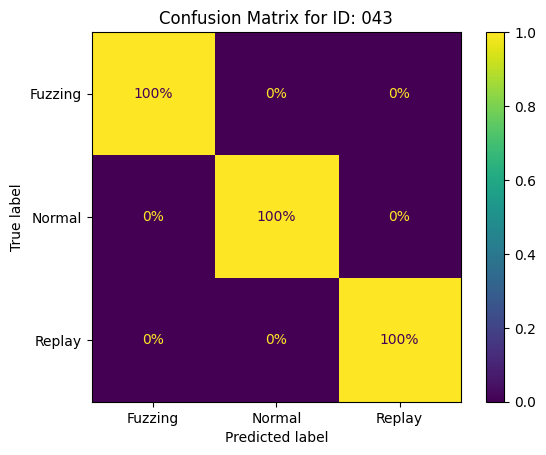

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       414
      Normal       1.00      1.00      1.00       243
      Replay       1.00      0.75      0.86         4

    accuracy                           1.00       661
   macro avg       1.00      0.92      0.95       661
weighted avg       1.00      1.00      1.00       661



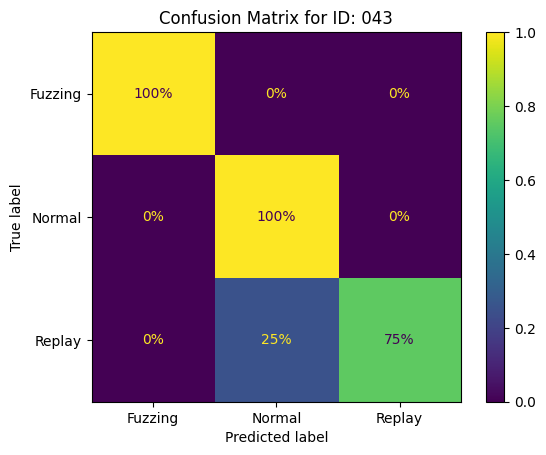

<Figure size 800x600 with 0 Axes>



Result 043 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          043       1.0       1.0       1.0       1.0
XGBoost                043  0.998487  0.998493  0.998487  0.998381


Processing ID: 52A
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       209
      Normal       0.99      1.00      1.00      2961
      Replay       1.00      0.00      0.00        17

    accuracy                           0.99      3187
   macro avg       1.00      0.67      0.67      3187
weighted avg       0.99      0.99      0.99      3187



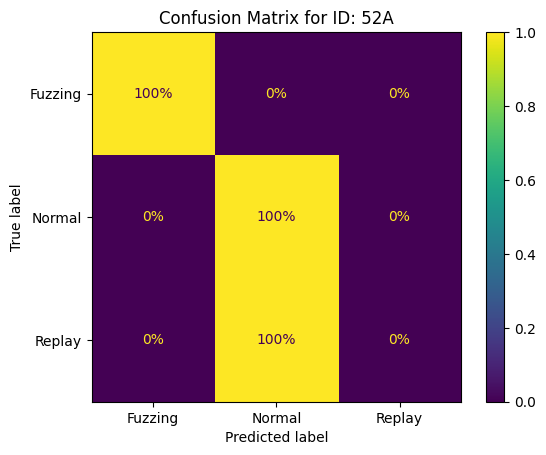

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       209
      Normal       1.00      1.00      1.00      2961
      Replay       0.88      0.88      0.88        17

    accuracy                           1.00      3187
   macro avg       0.96      0.96      0.96      3187
weighted avg       1.00      1.00      1.00      3187



<Figure size 800x600 with 0 Axes>



Result 52A models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          52A  0.994666  0.994696  0.994666  0.992006
XGBoost                52A  0.998745  0.998745  0.998745  0.998745


Processing ID: 544
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       190
      Normal       1.00      1.00      1.00      1281
      Replay       1.00      0.95      0.98        21

    accuracy                           1.00      1492
   macro avg       1.00      0.98      0.99      1492
weighted avg       1.00      1.00      1.00      1492



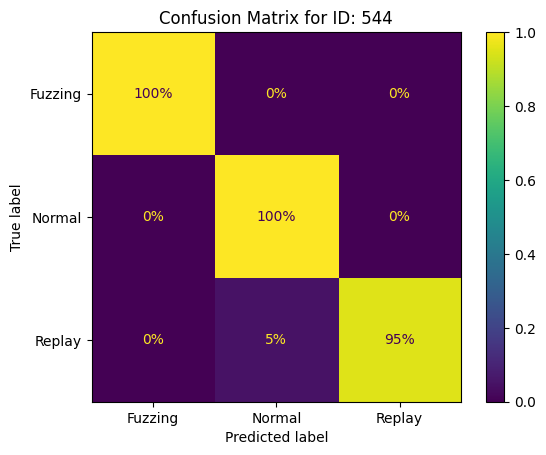

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       190
      Normal       1.00      1.00      1.00      1281
      Replay       0.95      0.95      0.95        21

    accuracy                           1.00      1492
   macro avg       0.98      0.98      0.98      1492
weighted avg       1.00      1.00      1.00      1492



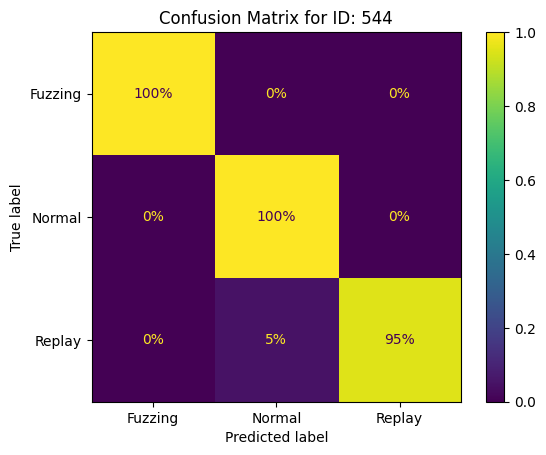

<Figure size 800x600 with 0 Axes>



Result 544 models:

              ProcessingID Accuracy Precision   Recall  F1 Score
Random Forest          544  0.99933   0.99933  0.99933  0.999322
XGBoost                544  0.99866   0.99866  0.99866   0.99866


Processing ID: 553
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       194
      Normal       0.99      1.00      0.99      1288
      Replay       1.00      0.16      0.27        19
    Spoofing       1.00      1.00      1.00       773

    accuracy                           0.99      2274
   macro avg       1.00      0.79      0.82      2274
weighted avg       0.99      0.99      0.99      2274



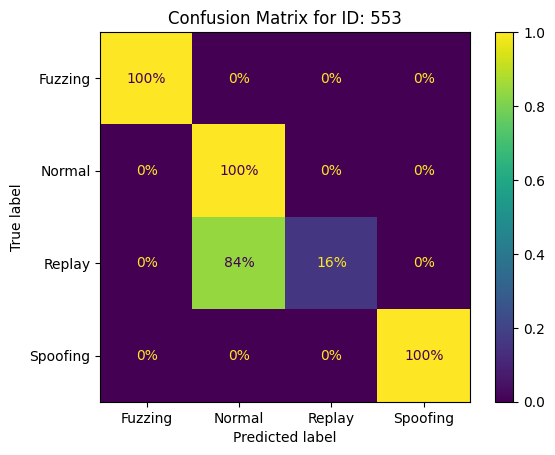

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       194
      Normal       1.00      1.00      1.00      1288
      Replay       0.90      1.00      0.95        19
    Spoofing       1.00      1.00      1.00       773

    accuracy                           1.00      2274
   macro avg       0.98      1.00      0.99      2274
weighted avg       1.00      1.00      1.00      2274



<Figure size 800x600 with 0 Axes>



Result 553 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          553  0.992964   0.99305  0.992964  0.990427
XGBoost                553  0.998681  0.998764  0.998681  0.998702


Processing ID: 559
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       211
      Normal       1.00      1.00      1.00      1271
      Replay       1.00      0.79      0.88        19

    accuracy                           1.00      1501
   macro avg       1.00      0.93      0.96      1501
weighted avg       1.00      1.00      1.00      1501



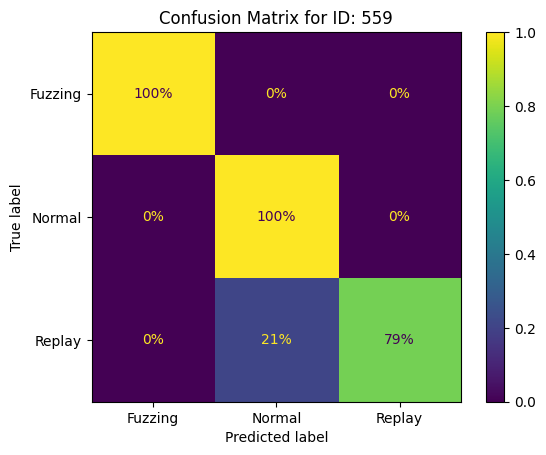

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       211
      Normal       1.00      1.00      1.00      1271
      Replay       1.00      0.79      0.88        19

    accuracy                           1.00      1501
   macro avg       1.00      0.93      0.96      1501
weighted avg       1.00      1.00      1.00      1501



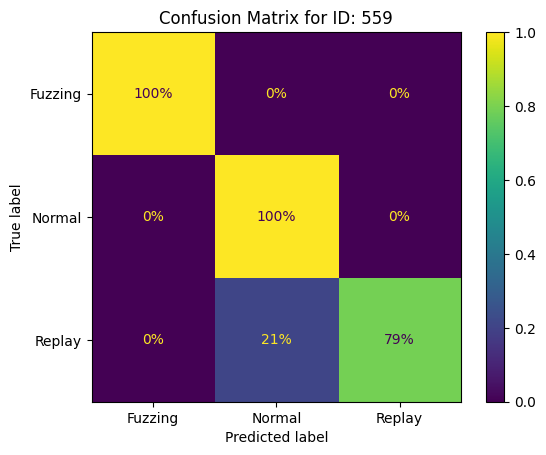

<Figure size 800x600 with 0 Axes>



Result 559 models:

              ProcessingID  Accuracy Precision    Recall F1 Score
Random Forest          559  0.997335  0.997343  0.997335  0.99718
XGBoost                559  0.997335  0.997343  0.997335  0.99718


Processing ID: 410
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00      1286
      Replay       1.00      0.88      0.93        16

    accuracy                           1.00      1505
   macro avg       1.00      0.96      0.98      1505
weighted avg       1.00      1.00      1.00      1505



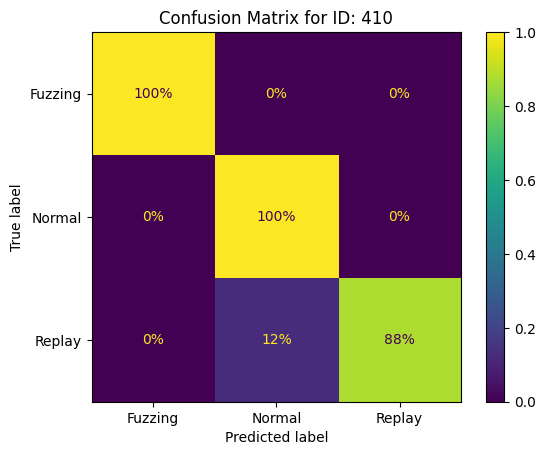

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00      1286
      Replay       1.00      0.88      0.93        16

    accuracy                           1.00      1505
   macro avg       1.00      0.96      0.98      1505
weighted avg       1.00      1.00      1.00      1505



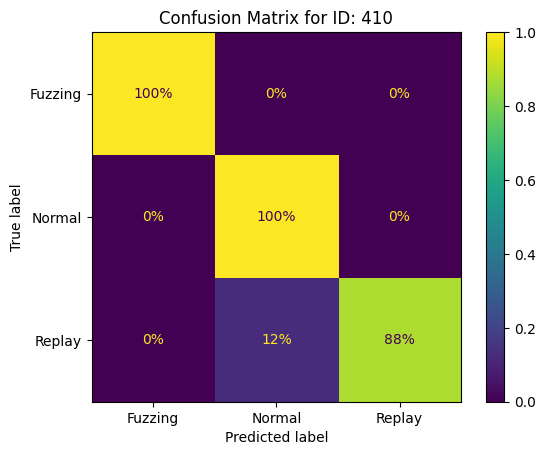

<Figure size 800x600 with 0 Axes>



Result 410 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          410  0.998671  0.998673  0.998671  0.998627
XGBoost                410  0.998671  0.998673  0.998671  0.998627


Processing ID: 563
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       206
      Normal       1.00      1.00      1.00       759
      Replay       0.80      0.80      0.80         5

    accuracy                           1.00       970
   macro avg       0.93      0.93      0.93       970
weighted avg       1.00      1.00      1.00       970



<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       206
      Normal       1.00      1.00      1.00       759
      Replay       1.00      0.60      0.75         5

    accuracy                           1.00       970
   macro avg       1.00      0.87      0.92       970
weighted avg       1.00      1.00      1.00       970



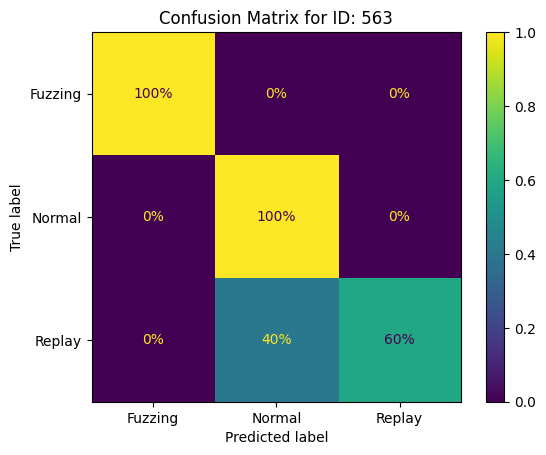

<Figure size 800x600 with 0 Axes>



Result 563 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          563  0.997938  0.997938  0.997938  0.997938
XGBoost                563  0.997938  0.997944  0.997938  0.997682


Processing ID: 07F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00       259
      Replay       1.00      1.00      1.00         2

    accuracy                           1.00       464
   macro avg       1.00      1.00      1.00       464
weighted avg       1.00      1.00      1.00       464



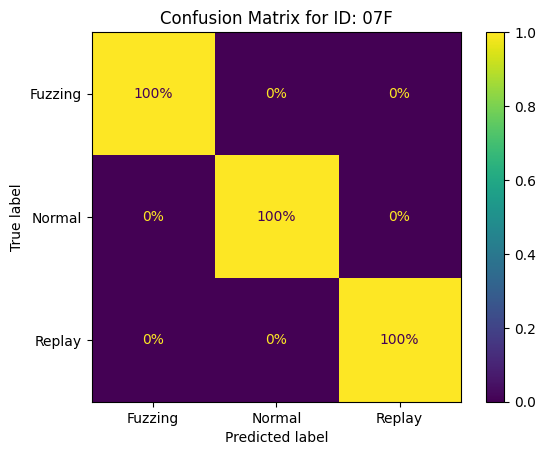

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       203
      Normal       1.00      1.00      1.00       259
      Replay       1.00      0.50      0.67         2

    accuracy                           1.00       464
   macro avg       1.00      0.83      0.89       464
weighted avg       1.00      1.00      1.00       464



<Figure size 800x600 with 0 Axes>



Result 07F models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          07F       1.0       1.0       1.0       1.0
XGBoost                07F  0.997845  0.997853  0.997845  0.997488


Processing ID: 57F
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.91      1.00      0.95       196
      Normal       1.00      0.86      0.93       132
      Replay       1.00      0.00      0.00         1

    accuracy                           0.94       329
   macro avg       0.97      0.62      0.63       329
weighted avg       0.95      0.94      0.94       329



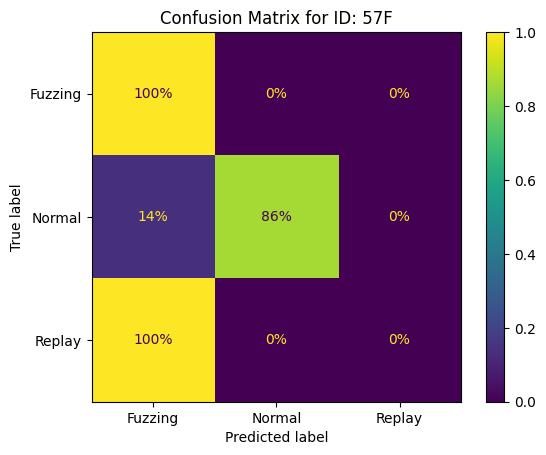

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       0.99      0.99      0.99       196
      Normal       0.98      0.99      0.99       132
      Replay       1.00      0.00      0.00         1

    accuracy                           0.99       329
   macro avg       0.99      0.66      0.66       329
weighted avg       0.99      0.99      0.99       329



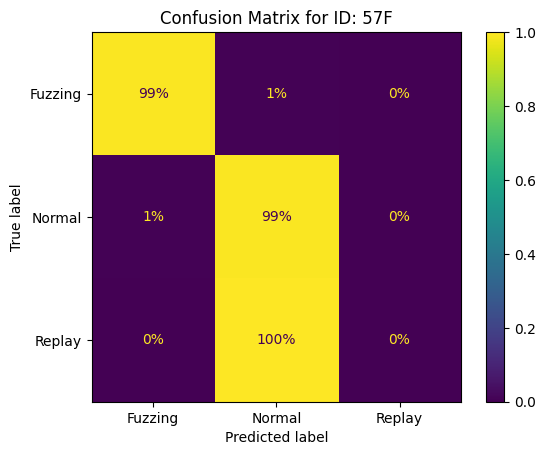

<Figure size 800x600 with 0 Axes>



Result 57F models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          57F  0.942249  0.947353  0.942249  0.940063
XGBoost                57F  0.990881  0.990927  0.990881  0.989379


Processing ID: 5B0
Random Forest Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       189
      Normal       1.00      1.00      1.00       272
      Replay       1.00      0.83      0.91         6

    accuracy                           1.00       467
   macro avg       1.00      0.94      0.97       467
weighted avg       1.00      1.00      1.00       467



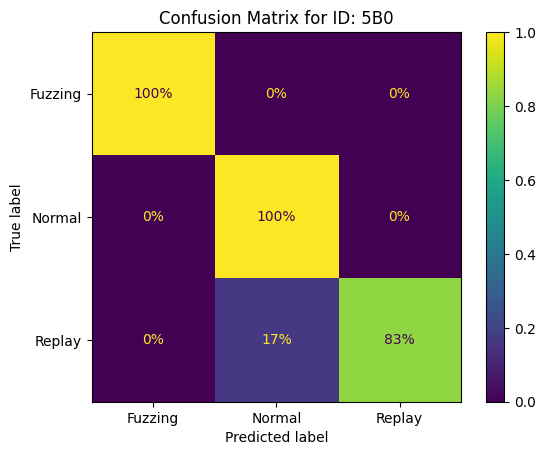

<Figure size 800x600 with 0 Axes>



XGBoost Classification Report:

              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       189
      Normal       1.00      1.00      1.00       272
      Replay       1.00      1.00      1.00         6

    accuracy                           1.00       467
   macro avg       1.00      1.00      1.00       467
weighted avg       1.00      1.00      1.00       467



<Figure size 800x600 with 0 Axes>



Result 5B0 models:

              ProcessingID  Accuracy Precision    Recall  F1 Score
Random Forest          5B0  0.997859  0.997867  0.997859  0.997763
XGBoost                5B0       1.0       1.0       1.0       1.0




In [ ]:
from sklearn.metrics import precision_recall_fscore_support

evaluation_results={}
df_results = pd.DataFrame()

for data_id in ids:
    print(f"Processing ID: {data_id}")
    y_test, preds, modelAcc, class_labels = id_train_test(dfs_by_id, data_id, models)

    for model_name in models:
        # precision, recall, f1-score 계산
        precision, recall, f1_score, support = precision_recall_fscore_support(y_test, preds[model_name], average='weighted', zero_division=1.0)

        # 결과를 딕셔너리에 저장
        evaluation_results[model_name] = {
            'ProcessingID': data_id,
            'Accuracy': modelAcc[model_name],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }

        print(f"{model_name} Classification Report:\n")
        print(classification_report(y_test, preds[model_name], target_names=class_labels, zero_division=1.0))

        # 혼동 행렬 계산 및 시각화
        disp = ConfusionMatrixDisplay.from_predictions(y_test, preds[model_name], display_labels=class_labels, normalize='true', values_format='.0%')

        # 시각화
        plt.title(f'Confusion Matrix for ID: {data_id}')
        #disp.plot(cmap=plt.cm.Blues)
        plt.figure(figsize=(8, 6))
        #cm = confusion_matrix(y_test, y_pred)
        plt.show()
        print("\n" + "="*80 + "\n")

    # 각 아이디별, 모델별 결과 저장
    df_results = pd.concat([df_results, pd.DataFrame(evaluation_results).T])

    # 결과 출력
    print(f'Result {data_id} models:\n')
    print(pd.DataFrame(evaluation_results).T)


    print("\n" + "="*80 + "\n")

### 모든 ID들의 성능의 평균치 계산
- Accuracy, F1-score, Precision의 평균 계산

In [ ]:
performance_IDs = df_results.reset_index().copy()
performance_IDs.rename(columns={'index': 'model'}, inplace=True)
performance_IDs = performance_IDs.round(6)
display(performance_IDs)

output_file = 'performance_scores_by_id.csv'
performance_IDs.to_csv(output_file, index=False)

model ProcessingID  Accuracy Precision    Recall  F1 Score
0    Random Forest          251  0.997922  0.997899  0.997922  0.997875
1          XGBoost          251  0.999207  0.999204  0.999207  0.999201
2    Random Forest          2B0  0.998109  0.998097  0.998109  0.998054
3          XGBoost          2B0  0.999319  0.999316  0.999319  0.999314
4    Random Forest          381  0.997506  0.997485  0.997506  0.997406
..             ...          ...       ...       ...       ...       ...
107        XGBoost          07F  0.997845  0.997853  0.997845  0.997488
108  Random Forest          57F  0.942249  0.947353  0.942249  0.940063
109        XGBoost          57F  0.990881  0.990927  0.990881  0.989379
110  Random Forest          5B0  0.997859  0.997867  0.997859  0.997763
111        XGBoost          5B0       1.0       1.0       1.0       1.0

[112 rows x 6 columns]

In [ ]:
# 전체 ID의 평균 성능 지표 계산
performance_IDs_mean = performance_IDs.drop(['ProcessingID'], axis=1).copy()
performance_IDs_mean.groupby('model').mean()

Accuracy Precision    Recall  F1 Score
model                                                
Random Forest  0.996102  0.996188  0.996102  0.995685
XGBoost        0.998447   0.99844  0.998447  0.998388

## 정리

1. Timediff값은 7번째부터는 의미가 없기 때문에 timediff6까지만 추가했다.
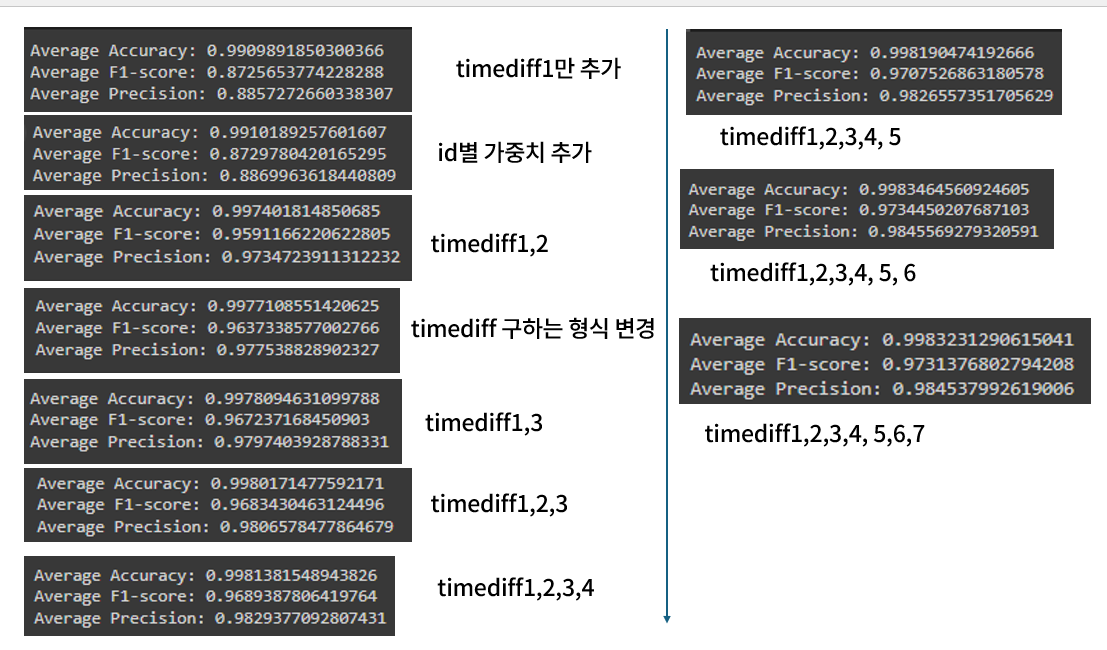

1.1 데이터 전처리 과정에서 concat 진행 후, timediff를 계산하니 성능이 조금 향상  
image.png

1.2 파라미터에 정규화 L1, L2 추가  
image.png

1.3 eta값 0.2로 변경  
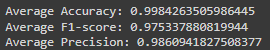

2. 각 ID별로 따져봤을때 timediff값을 추가했을때 더 좋은 성능을 내는 것을 볼 수 있다.
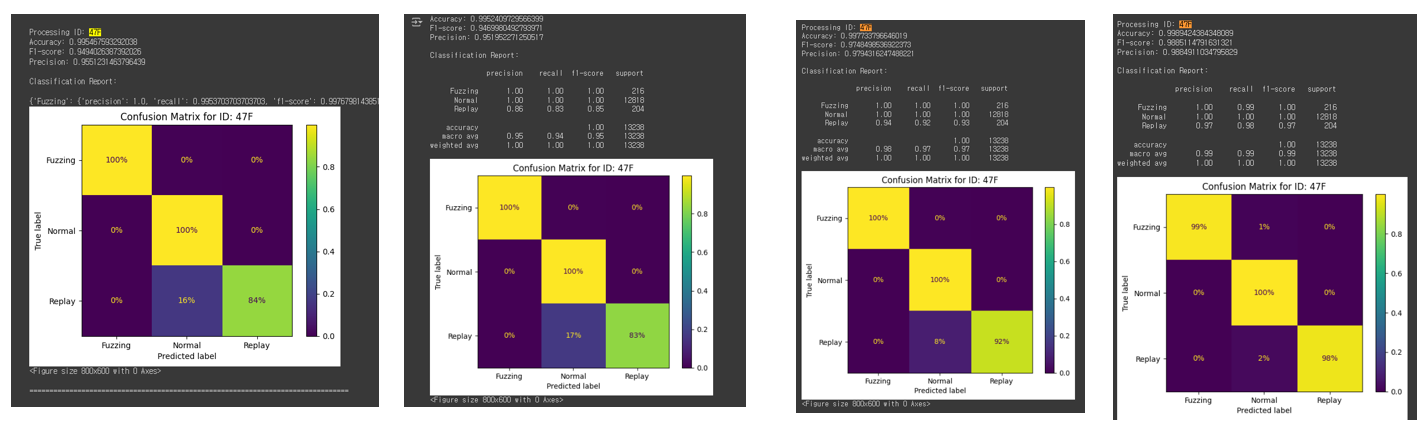

3. num_rounds 수를 200으로 증가시켜도 큰 의미는 없었다.

4. test_size의 경우 작을 경우 replay_attack이 test에 포함되지 않는 경우가 생기기 때문에 0.4로 설정했다. 0.35와 비교했을때 성능에 큰차이가 없었다.

# ID 356 성능 높이기 test
-- 진행전,,

In [ ]:
df_356 = dfs_by_id['df_356_combined']
df_356

Timestamp  Arbitration_ID SubClass  DLC  PAINT4  PAINT3  PAINT2  \
0        0.001354             356   Normal    8     0.0     2.0     3.0   
1        0.010779             356   Normal    8     0.0     2.0     3.0   
2        0.021718             356   Normal    8     0.0     2.0     3.0   
3        0.030786             356   Normal    8     0.0     2.0     3.0   
4        0.041039             356   Normal    8     0.0     2.0     3.0   
...           ...             ...      ...  ...     ...     ...     ...   
65677  167.398122             356   Normal    8     0.0     2.0     1.0   
65678  167.407674             356   Normal    8     0.0     2.0     1.0   
65679  167.417678             356   Normal    8     0.0     2.0     1.0   
65680  167.427378             356   Normal    8     0.0     2.0     1.0   
65681  167.438050             356   Normal    8     0.0     2.0     1.0   

       PAINT1  TimeDiff1  TimeDiff2  TimeDiff3  TimeDiff4  TimeDiff5  \
0         0.0   0.010000   0.020000   0.030000   0.040000   0.050000   
1         0.0   0.009425   0.020000   0.030000   0.040000   0.050000   
2         0.0   0.010939   0.020364   0.030000   0.040000   0.050000   
3         0.0   0.009068   0.020007   0.029432   0.040000   0.050000   
4         0.0   0.010253   0.019321   0.030260   0.039685   0.050000   
...       ...        ...        ...        ...        ...        ...   
65677     1.0   0.010853   0.020199   0.030836   0.040439   0.050683   
65678     1.0   0.009552   0.020405   0.029751   0.040388   0.049991   
65679     1.0   0.010004   0.019556   0.030409   0.039755   0.050392   
65680     1.0   0.009700   0.019704   0.029256   0.040109   0.049455   
65681     1.0   0.010672   0.020372   0.030376   0.039928   0.050781   

       TimeDiff6  
0       0.060000  
1       0.060000  
2       0.060000  
3       0.060000  
4       0.060000  
...          ...  
65677   0.060341  
65678   0.060235  
65679   0.059995  
65680   0.060092  
65681   0.060127  

[65682 rows x 14 columns]

In [ ]:
# 타겟 변수와 특징 변수 분리
X = df_356.drop('SubClass', axis=1)
y = df_356['SubClass']

# 데이터를 학습용과 테스트용으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# 클래스 레이블을 숫자로 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

train_classes = df_356['SubClass'].nunique()
print("df_356 SubClass count", train_classes)
print("df_356 SubClass Values", df_356['SubClass'].unique())
#print("\n")

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train_encoded, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test_encoded, enable_categorical=True)

# 하이퍼파라미터 설정
params = {
     'objective': 'multi:softmax',  # 다중 클래스 분류 문제
     'num_class': train_classes,    # 클래스 수
     'max_depth': 6,
     'eta': 0.2,     #0.3
     'eval_metric': 'merror',        # 분류 오차 평가 지표
     'lambda' : 1,                   #L2 정규화
     'alpha' : 0.5                   #L1 정규화
}


# 모델 학습
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# 예측 수행
y_pred_encoded = bst.predict(dtest)

# 예측 결과 디코딩 (숫자 -> 원래 클래스 레이블)
y_pred = label_encoder.inverse_transform(y_pred_encoded.astype(int))

df_356 SubClass count 3
df_356 SubClass Values ['Normal', 'Replay', 'Fuzzing']
Categories (3, object): ['Fuzzing', 'Normal', 'Replay']


Accuracy: 0.9960415635823849
F1-score: 0.9315248087117082
Precision: 0.9734664903525996


              precision    recall  f1-score   support

     Fuzzing       0.98      0.80      0.88       215
      Normal       1.00      1.00      1.00     25662
      Replay       0.95      0.89      0.92       396

    accuracy                           1.00     26273
   macro avg       0.97      0.90      0.93     26273
weighted avg       1.00      1.00      1.00     26273



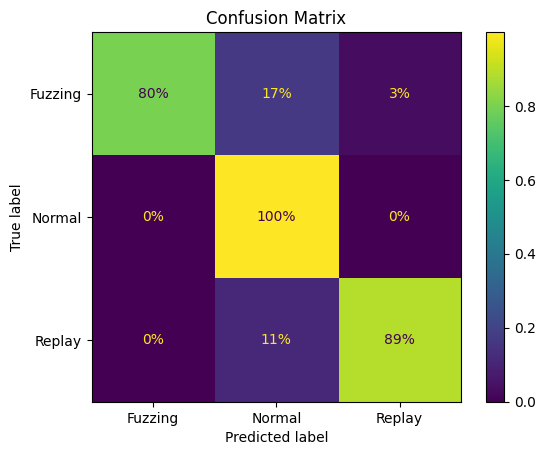

<Figure size 800x600 with 0 Axes>

In [ ]:
_# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# F1-score 계산
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1-score: {f1}')

# Precision 계산
precision = precision_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')

# 분류 보고서 출력
print("\n")
print(classification_report(y_test, y_pred))

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화 (퍼센트로 정규화)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, normalize='true', values_format='.0%')

# 시각화
plt.title('Confusion Matrix')
plt.figure(figsize=(8, 6))
plt.show()

##data 파악

In [ ]:
df_356

Timestamp  Arbitration_ID SubClass  DLC  PAINT4  PAINT3  PAINT2  \
0        0.001354             356   Normal    8     0.0     2.0     3.0   
1        0.010779             356   Normal    8     0.0     2.0     3.0   
2        0.021718             356   Normal    8     0.0     2.0     3.0   
3        0.030786             356   Normal    8     0.0     2.0     3.0   
4        0.041039             356   Normal    8     0.0     2.0     3.0   
...           ...             ...      ...  ...     ...     ...     ...   
65677  167.398122             356   Normal    8     0.0     2.0     1.0   
65678  167.407674             356   Normal    8     0.0     2.0     1.0   
65679  167.417678             356   Normal    8     0.0     2.0     1.0   
65680  167.427378             356   Normal    8     0.0     2.0     1.0   
65681  167.438050             356   Normal    8     0.0     2.0     1.0   

       PAINT1  TimeDiff1  TimeDiff2  TimeDiff3  TimeDiff4  TimeDiff5  \
0         0.0   0.010000   0.020000   0.030000   0.040000   0.050000   
1         0.0   0.009425   0.020000   0.030000   0.040000   0.050000   
2         0.0   0.010939   0.020364   0.030000   0.040000   0.050000   
3         0.0   0.009068   0.020007   0.029432   0.040000   0.050000   
4         0.0   0.010253   0.019321   0.030260   0.039685   0.050000   
...       ...        ...        ...        ...        ...        ...   
65677     1.0   0.010853   0.020199   0.030836   0.040439   0.050683   
65678     1.0   0.009552   0.020405   0.029751   0.040388   0.049991   
65679     1.0   0.010004   0.019556   0.030409   0.039755   0.050392   
65680     1.0   0.009700   0.019704   0.029256   0.040109   0.049455   
65681     1.0   0.010672   0.020372   0.030376   0.039928   0.050781   

       TimeDiff6  
0       0.060000  
1       0.060000  
2       0.060000  
3       0.060000  
4       0.060000  
...          ...  
65677   0.060341  
65678   0.060235  
65679   0.059995  
65680   0.060092  
65681   0.060127  

[65682 rows x 14 columns]

In [ ]:
print(df_356.value_counts('PAINT4'))
print(df_356.value_counts('PAINT3'))
print(df_356.value_counts('PAINT2'))
print(df_356.value_counts('PAINT1'))

PAINT4
0.0    63098
1.0     2584
Name: count, dtype: int64
PAINT3
3.0    26967
2.0    15592
0.0    12658
1.0    10465
Name: count, dtype: int64
PAINT2
1.0    18442
3.0    16486
2.0    16087
0.0    14667
Name: count, dtype: int64
PAINT1
0.0    33633
1.0    32049
Name: count, dtype: int64


In [ ]:
df_356.value_counts('SubClass')

SubClass
Normal     64199
Replay       990
Fuzzing      493
Name: count, dtype: int64

In [ ]:
Normal_356 = df_356[df_356['SubClass'] == 'Normal']
Fuzzing_356 = df_356[df_356['SubClass'].isin(['Fuzzing'])]
Replay_356 = df_356[df_356['SubClass'].isin(['Replay'])]

Fuzzing_356

Timestamp  Arbitration_ID SubClass  DLC  PAINT4  PAINT3  PAINT2  \
12969  127.444929             356  Fuzzing    8     1.0     0.0     1.0   
12990  127.647377             356  Fuzzing    8     1.0     1.0     2.0   
12991  127.648984             356  Fuzzing    8     1.0     3.0     1.0   
13009  127.819518             356  Fuzzing    8     1.0     0.0     0.0   
13052  128.234013             356  Fuzzing    8     0.0     0.0     0.0   
...           ...             ...      ...  ...     ...     ...     ...   
60879  119.467201             356  Fuzzing    8     0.0     2.0     2.0   
60911  119.774847             356  Fuzzing    8     0.0     2.0     3.0   
60918  119.838039             356  Fuzzing    8     0.0     0.0     2.0   
60921  119.856265             356  Fuzzing    8     1.0     1.0     1.0   
60939  120.022415             356  Fuzzing    8     0.0     3.0     1.0   

       PAINT1  TimeDiff1  TimeDiff2  TimeDiff3  TimeDiff4  TimeDiff5  \
12969     0.0   0.002916   0.012592   0.023020   0.032812   0.042928   
12990     1.0   0.005537   0.015274   0.025528   0.035257   0.045306   
12991     1.0   0.001607   0.007144   0.016881   0.027135   0.036864   
13009     1.0   0.007568   0.017481   0.027620   0.037682   0.047405   
13052     1.0   0.002031   0.011991   0.021874   0.032164   0.042119   
...       ...        ...        ...        ...        ...        ...   
60879     1.0   0.008746   0.018771   0.028676   0.038782   0.049542   
60911     0.0   0.006846   0.015575   0.026409   0.036448   0.047188   
60918     0.0   0.009609   0.019478   0.029950   0.039360   0.051042   
60921     1.0   0.007841   0.017726   0.018226   0.027835   0.037704   
60939     0.0   0.003800   0.015325   0.023087   0.033974   0.043897   

       TimeDiff6  
12969   0.053634  
12990   0.055260  
12991   0.046913  
13009   0.057687  
13052   0.052173  
...          ...  
60879   0.058603  
60911   0.056296  
60918   0.059536  
60921   0.048176  
60939   0.054410  

[493 rows x 14 columns]

In [ ]:
import matplotlib.pyplot as plt

# 그래프 그리기
fig, axes = plt.subplots(3, 4, figsize=(10, 8))

# Normal_356의 PAINT4, PAINT3, PAINT2, PAINT1 값 빈도 그래프
Normal_356['PAINT4'].value_counts().plot(kind='bar', ax=axes[0, 0], title='Normal_356 PAINT4')
Normal_356['PAINT3'].value_counts().plot(kind='bar', ax=axes[0, 1], title='Normal_356 PAINT3')
Normal_356['PAINT2'].value_counts().plot(kind='bar', ax=axes[0, 2], title='Normal_356 PAINT2')
Normal_356['PAINT1'].value_counts().plot(kind='bar', ax=axes[0, 3], title='Normal_356 PAINT1')

# Attack_356의 PAINT4, PAINT3, PAINT2, PAINT1 값 빈도 그래프
Fuzzing_356['PAINT4'].value_counts().plot(kind='bar', ax=axes[1, 0], title='Fuzzing_356 PAINT4', color = 'red')
Fuzzing_356['PAINT3'].value_counts().plot(kind='bar', ax=axes[1, 1], title='Fuzzing_356 PAINT3', color = 'red')
Fuzzing_356['PAINT2'].value_counts().plot(kind='bar', ax=axes[1, 2], title='Fuzzing_356 PAINT2', color = 'red')
Fuzzing_356['PAINT1'].value_counts().plot(kind='bar', ax=axes[1, 3], title='Fuzzing_356 PAINT1', color = 'red')

# Attack_356의 PAINT4, PAINT3, PAINT2, PAINT1 값 빈도 그래프
Replay_356['PAINT4'].value_counts().plot(kind='bar', ax=axes[2, 0], title='Replay_356 PAINT4', color = 'green')
Replay_356['PAINT3'].value_counts().plot(kind='bar', ax=axes[2, 1], title='Replay_356 PAINT3', color = 'green')
Replay_356['PAINT2'].value_counts().plot(kind='bar', ax=axes[2, 2], title='Replay_356 PAINT2', color = 'green')
Replay_356['PAINT1'].value_counts().plot(kind='bar', ax=axes[2, 3], title='Replay_356 PAINT1', color = 'green')

plt.tight_layout()
plt.show()


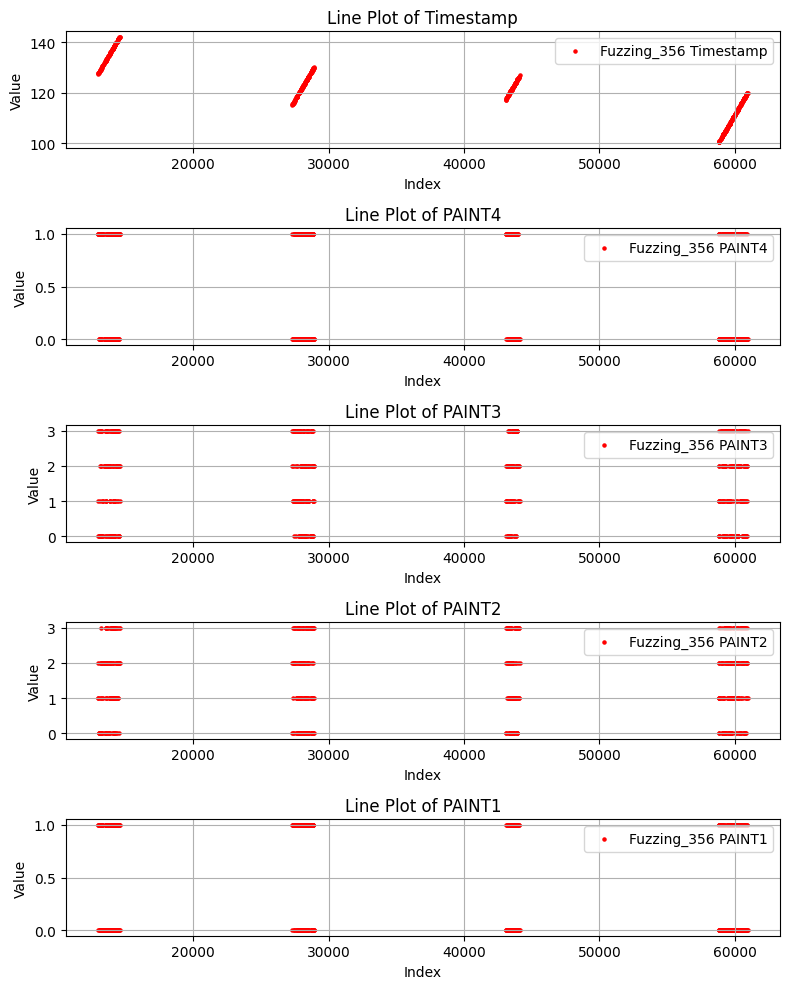

In [ ]:
import matplotlib.pyplot as plt

columns_of_interest = ['Timestamp','PAINT4', 'PAINT3', 'PAINT2', 'PAINT1']

plt.figure(figsize=(8, 10))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(len(columns_of_interest), 1, i)
    plt.scatter(Fuzzing_356.index, Fuzzing_356[column], label=f'Fuzzing_356 {column}', color='red', s=5)  # 점으로 변경, s는 점의 크기
    #plt.scatter(Replay_356.index, Replay_356[column], label=f'Replay_356 {column}', color='green', s=5)  # 점으로 변경, s는 점의 크기
    #plt.scatter(Normal_356.index, Normal_356[column], label=f'Normal_356 {column}', color='blue', s=5)  # 점으로 변경, s는 점의 크기
    plt.title(f'Line Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


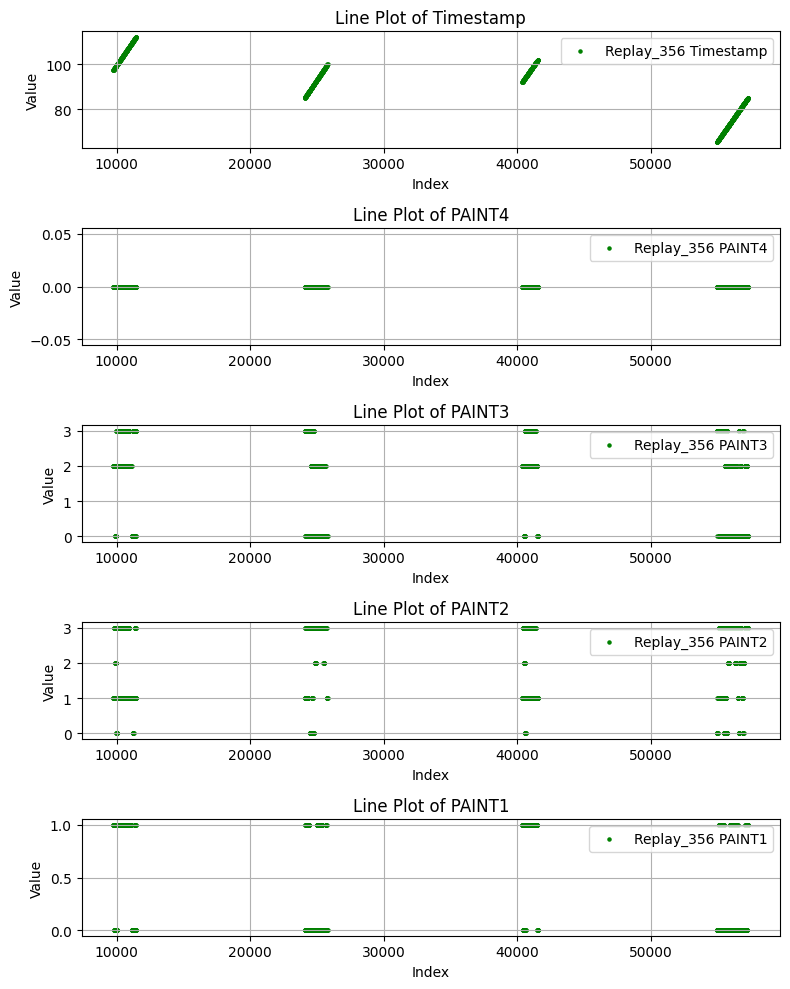

In [ ]:
import matplotlib.pyplot as plt

columns_of_interest = ['Timestamp','PAINT4', 'PAINT3', 'PAINT2', 'PAINT1']

plt.figure(figsize=(8, 10))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(len(columns_of_interest), 1, i)
    #plt.scatter(Fuzzing_356.index, Fuzzing_356[column], label=f'Fuzzing_356 {column}', color='red', s=5)  # 점으로 변경, s는 점의 크기
    plt.scatter(Replay_356.index, Replay_356[column], label=f'Replay_356 {column}', color='green', s=5)  # 점으로 변경, s는 점의 크기
    #plt.scatter(Normal_356.index, Normal_356[column], label=f'Normal_356 {column}', color='blue', s=5)  # 점으로 변경, s는 점의 크기
    plt.title(f'Line Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

columns_of_interest = ['Timestamp','PAINT4', 'PAINT3', 'PAINT2', 'PAINT1']

plt.figure(figsize=(8, 10))

for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(len(columns_of_interest), 1, i)
    #plt.scatter(Attack_356.index, Attack_356[column], label=f'Attack_356 {column}', color='red', s=5)  # 점으로 변경, s는 점의 크기
    plt.scatter(Normal_356.index, Normal_356[column], label=f'Normal_356 {column}', color='blue', s=5)  # 점으로 변경, s는 점의 크기
    plt.title(f'Line Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
